<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day2/Day2_theta_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Theta Model 시계열 분석 실습 1

Theta Model은 간단하면서도 강력한 시계열 예측 방법입니다.

주요 특징:
- 2000년 M3 Competition에서 우수한 성과
- SES(Simple Exponential Smoothing)와 Linear Trend의 조합
- Theta 파라미터로 예측의 곡률(curvature) 조정
- 빠른 계산 속도와 해석 용이성

Theta 파라미터:
- theta = 1: Linear trend
- theta = 2: Classical Theta (default)
- theta > 2: 더 강한 추세
- theta = ∞: Pure linear extrapolation

본 실습에서는 경제 지표 예측에 theta model을 활용해 보겠습니다.
참고: https://www.statsmodels.org/dev/examples/notebooks/generated/theta-model.html

## 1. 라이브러리 로드 및 설정

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
from statsmodels.tsa.forecasting.theta import ThetaModel
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
sns.set_palette("husl")

## 2. 데이터 로드 - 주택 착공 건수 (Housing Starts)


출처: FRED (Federal Reserve Economic Data)

코드: HOUST (Housing Starts: Total: New Privately Owned)

기간: 1980-01 ~ 2020-04

빈도: Monthly

In [2]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"

housing_data_path = urljoin(data_repo_url, "housing_starts.csv")
housing = pd.read_csv(housing_data_path, index_col=0, parse_dates=True)
housing.index.freq = housing.index.inferred_freq
housing = housing.HOUST

In [3]:
housing.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 484 entries, 1980-01-01 to 2020-04-01
Freq: MS
Series name: HOUST
Non-Null Count  Dtype
--------------  -----
484 non-null    int64
dtypes: int64(1)
memory usage: 7.6 KB


In [4]:
housing.describe()

count     484.000000
mean     1350.057851
std       388.439913
min       478.000000
25%      1090.250000
50%      1375.500000
75%      1628.250000
max      2273.000000
Name: HOUST, dtype: float64

In [5]:
housing.isnull().sum()

np.int64(0)

## 3. EDA

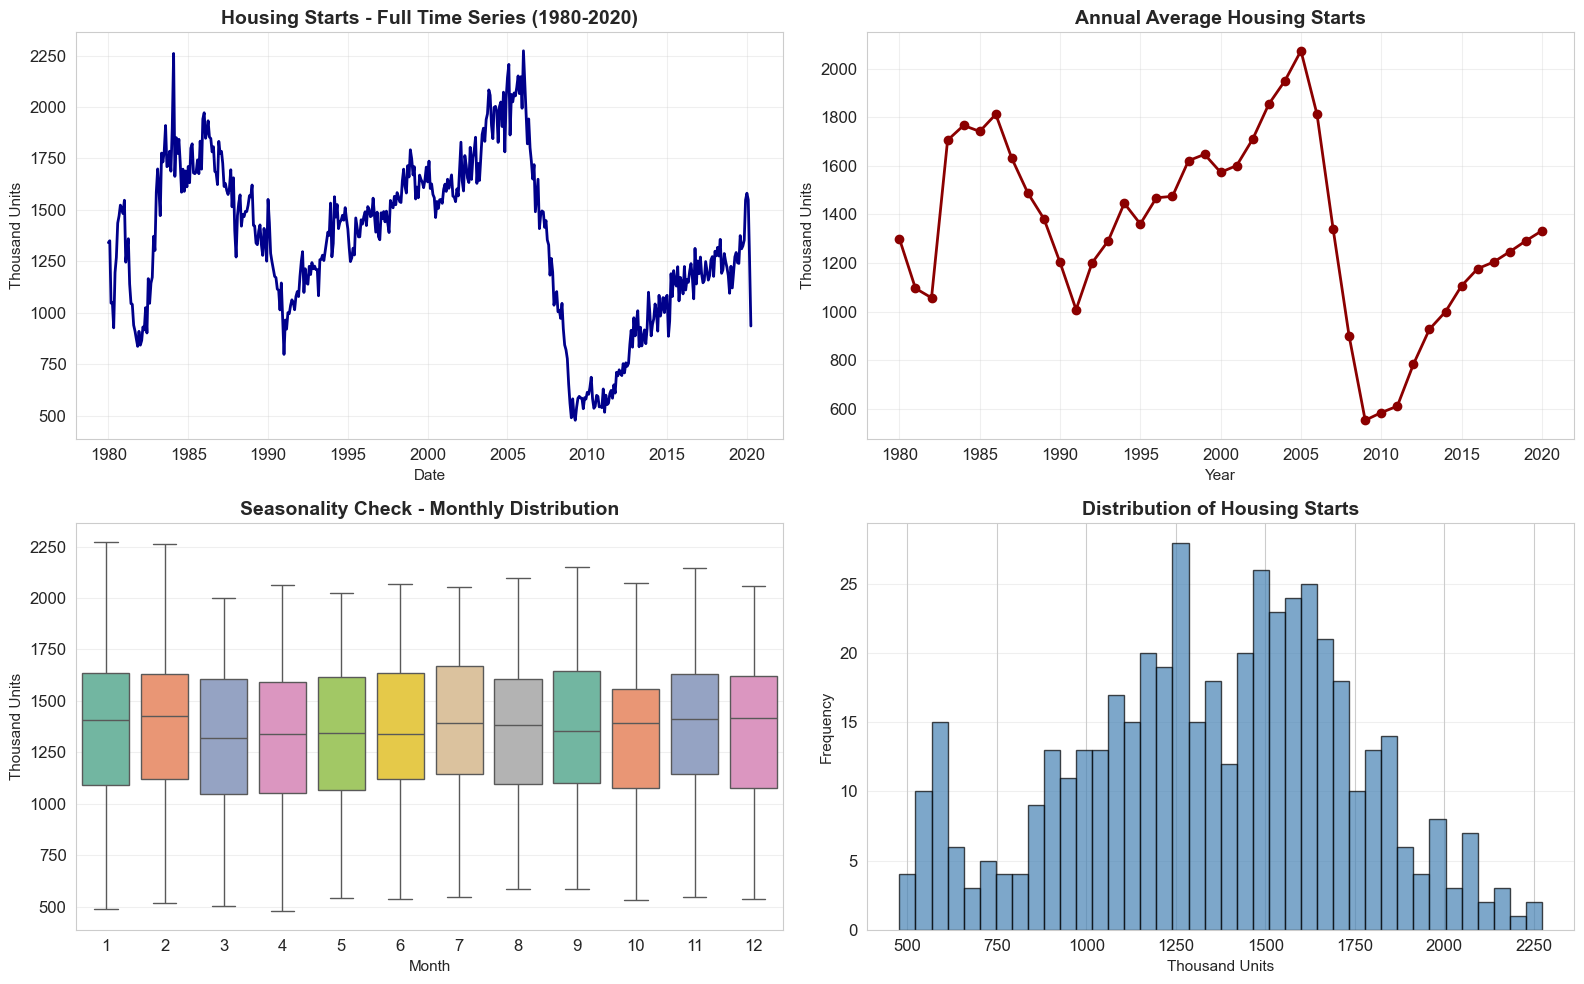

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 전체 시계열
axes[0, 0].plot(housing.index, housing.values, color='darkblue', linewidth=2)
axes[0, 0].set_title('Housing Starts - Full Time Series (1980-2020)',
                      fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Thousand Units', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 연도별 평균
yearly_avg = housing.groupby(housing.index.year).mean()
axes[0, 1].plot(yearly_avg.index, yearly_avg.values,
                marker='o', markersize=6, color='darkred', linewidth=2)
axes[0, 1].set_title('Annual Average Housing Starts', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Year', fontsize=11)
axes[0, 1].set_ylabel('Thousand Units', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 월별 박스플롯 (계절성 확인)
monthly_data = pd.DataFrame({
    'value': housing.values,
    'month': housing.index.month
})
sns.boxplot(data=monthly_data, x='month', y='value', hue='month', ax=axes[1, 0], palette='Set2', legend=False)
axes[1, 0].set_title('Seasonality Check - Monthly Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month', fontsize=11)
axes[1, 0].set_ylabel('Thousand Units', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 히스토그램
axes[1, 1].hist(housing.values, bins=40, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 1].set_title('Distribution of Housing Starts', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Thousand Units', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. 기본 Theta Model 적용

| 파라미터      | 의미                      | 해석                                                                                            |
| --------- | ----------------------- | --------------------------------------------------------------------------------------------- |
| **b0**    | 추세(drift) 보정 상수         | 데이터의 장기적 증가/감소 방향을 보정하는 절편. 음수이면 약간의 하락 추세를 보정하는 역할.                                          |
| **alpha** | SES의 평활화 계수 (0 < α < 1) | 최근 데이터에 얼마나 가중을 줄지 결정. <br> α가 높을수록 최근 관측치에 민감하고 예측이 빠르게 반응함. <br> α가 낮을수록 평활하고 장기적인 움직임에 중점. |


In [7]:
# 기본 Theta 모델 (theta=2, multiplicative method)
tm = ThetaModel(housing)
res = tm.fit()

print(res.summary())

                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  484
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sat, 11 Oct 2025   Deseas. Method:         Multiplicative
Time:                        12:56:15   Period:                             12
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0    -0.9185839033748168
alpha  0.6165175851279336
-------------------------


In [8]:
print("\n주요 파라미터:")
print(f"  Alpha (smoothing parameter): {res.params['alpha']:.4f}")
print(f"  b0 (initial level): {res.params['b0']:.2f}")
print(f"\nTheta Model = (1-alpha) * SES + alpha * Linear Trend")
print(f"Alpha = {res.params['alpha']:.4f} means {res.params['alpha']*100:.1f}% weight on trend component")


주요 파라미터:
  Alpha (smoothing parameter): 0.6165
  b0 (initial level): -0.92

Theta Model = (1-alpha) * SES + alpha * Linear Trend
Alpha = 0.6165 means 61.7% weight on trend component



향후 12개월 예측:
2020-05-01    1100.238221
2020-06-01    1094.127988
2020-07-01    1103.264683
2020-08-01    1095.218318
2020-09-01    1094.980179
Freq: MS, Name: forecast, dtype: float64


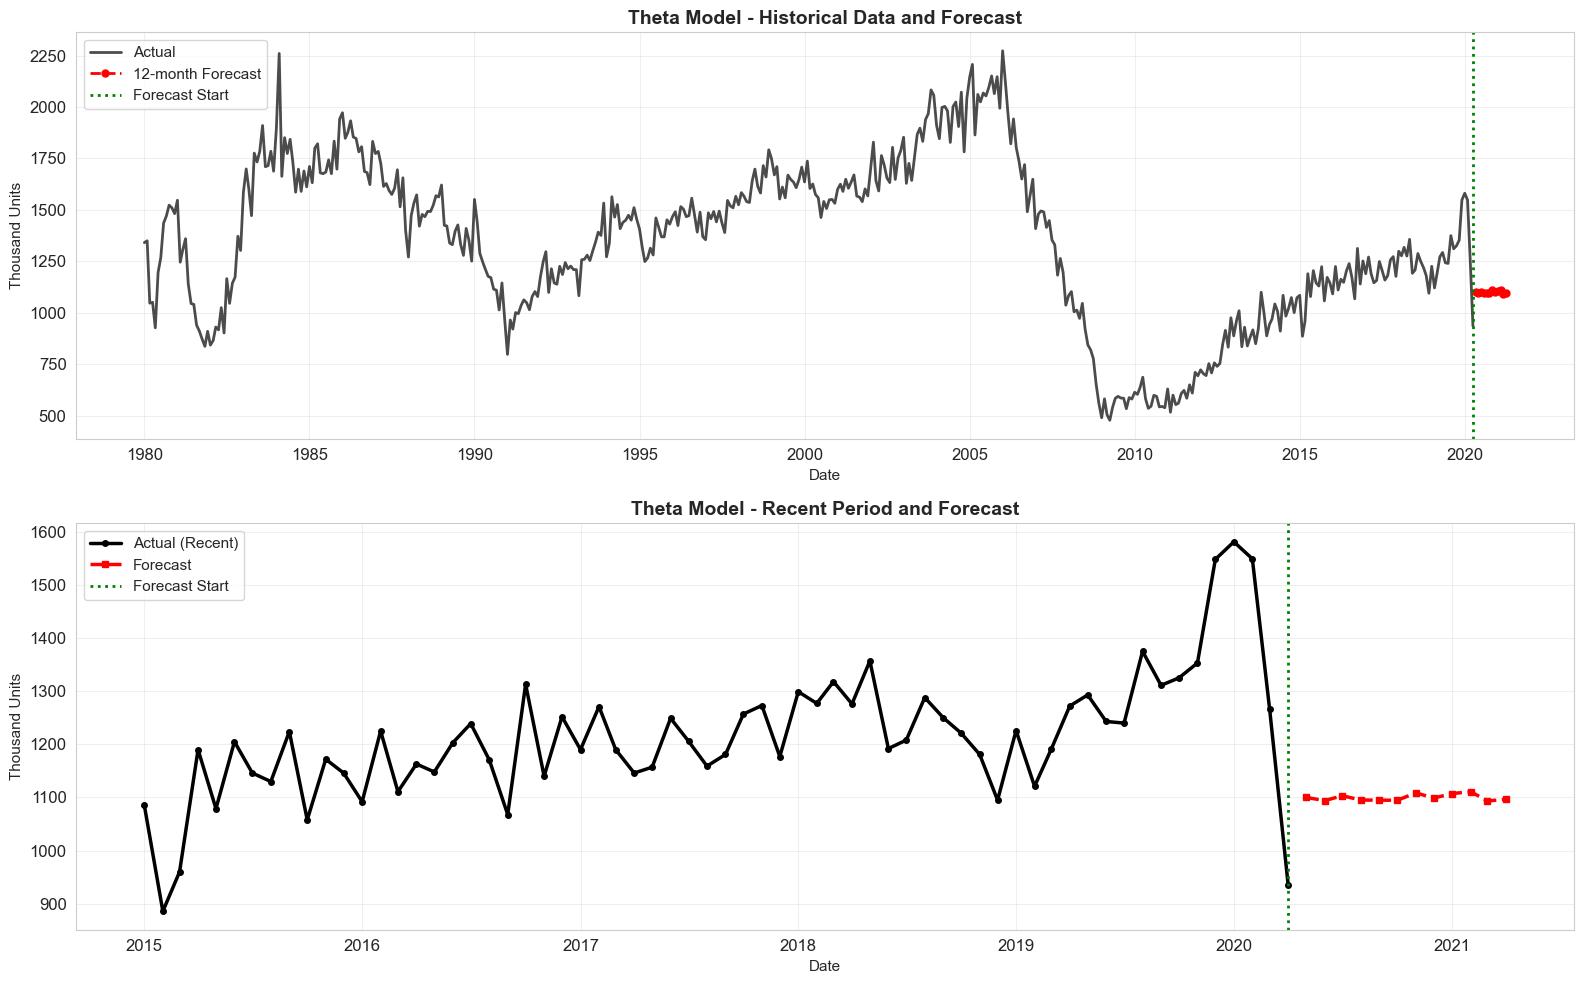

In [9]:
# 예측 결과 확인
forecast_12 = res.forecast(12)
print(f"\n향후 12개월 예측:")
print(forecast_12.head())

# 전체 시계열 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 원본 데이터와 예측
axes[0].plot(housing.index, housing.values, label='Actual',
             color='black', linewidth=2, alpha=0.7)
axes[0].plot(forecast_12.index, forecast_12.values, label='12-month Forecast',
             color='red', linewidth=2, linestyle='--', marker='o', markersize=5)
axes[0].axvline(x=housing.index[-1], color='green', linestyle=':',
                linewidth=2, label='Forecast Start')
axes[0].set_title('Theta Model - Historical Data and Forecast',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date', fontsize=11)
axes[0].set_ylabel('Thousand Units', fontsize=11)
axes[0].legend(loc='upper left', fontsize=11)
axes[0].grid(True, alpha=0.3)

# 최근 5년 + 예측 확대
recent = housing['2015':]
axes[1].plot(recent.index, recent.values, label='Actual (Recent)',
             color='black', linewidth=2.5, marker='o', markersize=4)
axes[1].plot(forecast_12.index, forecast_12.values, label='Forecast',
             color='red', linewidth=2.5, linestyle='--', marker='s', markersize=5)
axes[1].axvline(x=housing.index[-1], color='green', linestyle=':',
                linewidth=2, label='Forecast Start')
axes[1].set_title('Theta Model - Recent Period and Forecast', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_ylabel('Thousand Units', fontsize=11)
axes[1].legend(loc='upper left', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 5. 백테스팅 (Backtesting) - 시간에 따른 예측 성능

1995년부터 2년 간격으로 24개월 예측을 수행합니다.

In [10]:
# 각 시점에서 24개월 예측
forecasts = {"Actual": housing}
performance_metrics = []

for year in range(1995, 2020, 2):
    # 해당 연도까지의 데이터로 모델 학습
    sub = housing[: str(year)]
    res_sub = ThetaModel(sub).fit()

    # 24개월 예측
    fcast = res_sub.forecast(24)
    forecasts[str(year)] = fcast

    # 성능 평가 (예측 기간과 실제 데이터가 겹치는 부분)
    actual_period = housing[fcast.index[0]:fcast.index[-1]]
    if len(actual_period) > 0:
        mae = mean_absolute_error(actual_period, fcast[:len(actual_period)])
        rmse = root_mean_squared_error(actual_period, fcast[:len(actual_period)])
        performance_metrics.append({
            'Year': year,
            'MAE': mae,
            'RMSE': rmse
        })

forecasts_df = pd.DataFrame(forecasts)


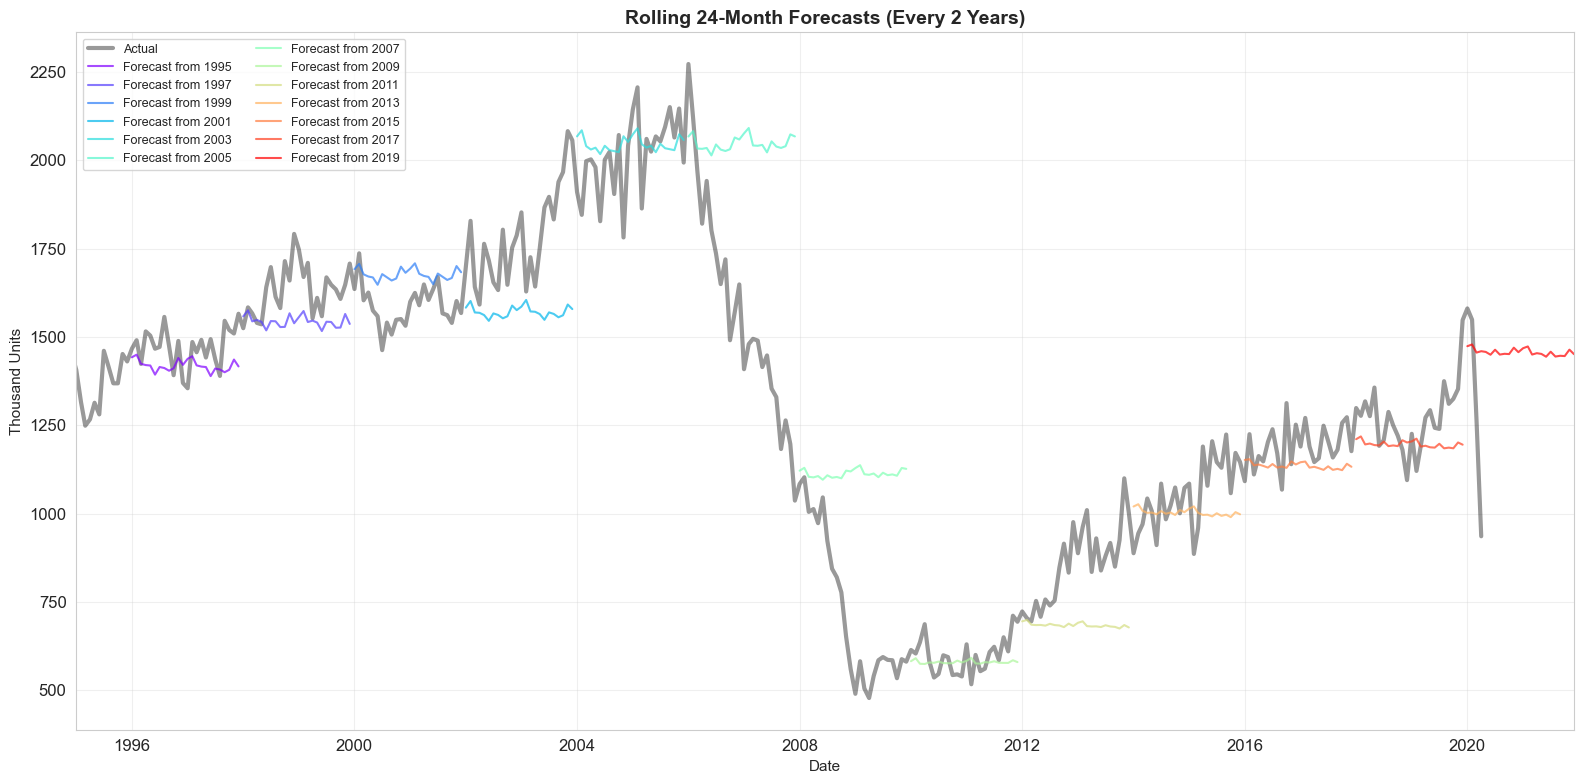

In [11]:
# 시각화: 전체 예측 결과만
fig, ax1 = plt.subplots(figsize=(16, 8))

# 실제값
ax1.plot(forecasts_df.index, forecasts_df['Actual'],
         linewidth=3, alpha=0.4, color='black', label='Actual', zorder=1)

# 각 연도의 예측값
colors = plt.cm.rainbow(np.linspace(0, 1, len(range(1995, 2020, 2))))
for idx, year in enumerate(range(1995, 2020, 2)):
    if str(year) in forecasts_df.columns:
        ax1.plot(forecasts_df.index, forecasts_df[str(year)],
                 linewidth=1.5, alpha=0.7, color=colors[idx],
                 label=f'Forecast from {year}', zorder=2)

ax1.set_title('Rolling 24-Month Forecasts (Every 2 Years)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Thousand Units', fontsize=11)
ax1.legend(loc='upper left', fontsize=9, ncol=2)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(forecasts_df.index[forecasts_df.index >= '1995-01-01'].min(),
             forecasts_df.index.max())

plt.tight_layout()
plt.show()



백테스팅 성능 지표 (24개월 예측):
 Year        MAE       RMSE
 1995  66.774737  78.587820
 1997  94.046344 114.902840
 1999  92.687117 104.399679
 2001 210.654975 249.226552
 2003  84.866143 113.203159
 2005 491.404920 558.673266
 2007 386.367951 441.780438
 2009  44.167570  55.001551
 2011 171.511090 204.341696
 2013  95.073896 114.142032
 2015  68.319548  81.984446
 2017  91.081492 117.919750
 2019 222.706091 285.902435


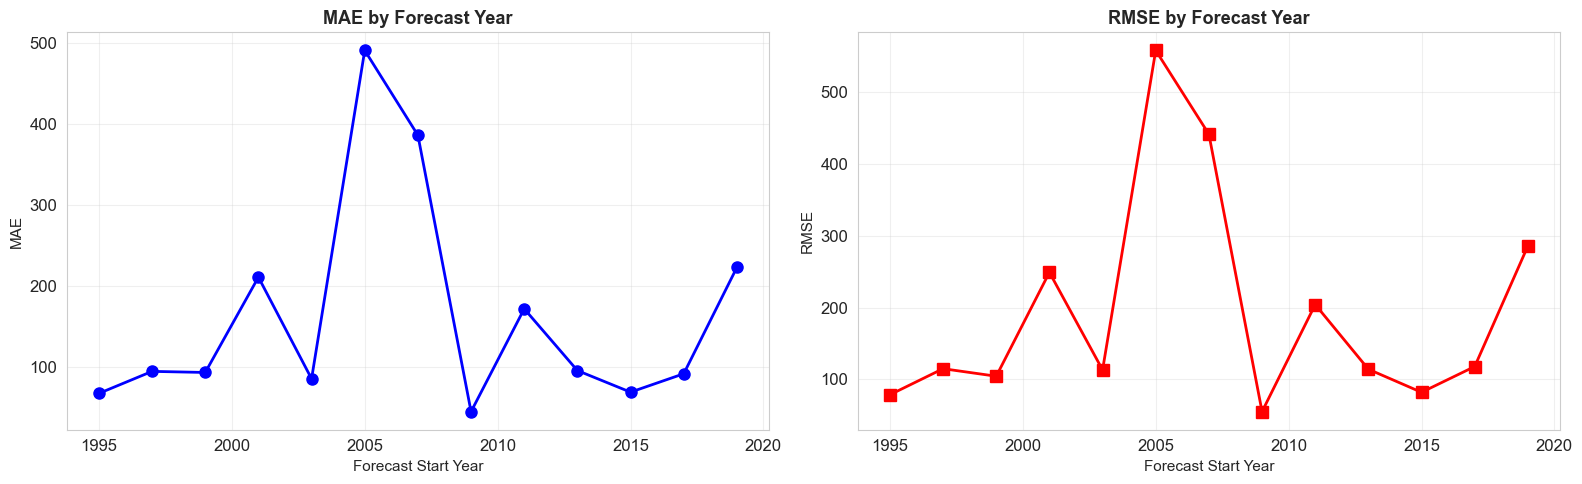

In [12]:
# 성능 지표 출력
if performance_metrics:
    perf_df = pd.DataFrame(performance_metrics)
    print("\n백테스팅 성능 지표 (24개월 예측):")
    print(perf_df.to_string(index=False))

    # 성능 추이 시각화
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    axes[0].plot(perf_df['Year'], perf_df['MAE'], marker='o',
                 markersize=8, linewidth=2, color='blue')
    axes[0].set_title('MAE by Forecast Year', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Forecast Start Year', fontsize=11)
    axes[0].set_ylabel('MAE', fontsize=11)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(perf_df['Year'], perf_df['RMSE'], marker='s',
                 markersize=8, linewidth=2, color='red')
    axes[1].set_title('RMSE by Forecast Year', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Forecast Start Year', fontsize=11)
    axes[1].set_ylabel('RMSE', fontsize=11)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 6. Log Transformation & Additive Method

원본 데이터에 로그 변환을 적용하고 additive method를 사용합니다. 이는 분산을 안정화하고 비율 변화를 선형화하는 효과가 있습니다.

In [13]:
# 로그 변환
log_housing = np.log(housing)

In [14]:
# 1. Multiplicative method (기본)
tm_mult = ThetaModel(log_housing, method="multiplicative")
res_mult = tm_mult.fit()

# 2. Additive method with MLE
tm_log = ThetaModel(log_housing, method="additive")
res_log = tm_log.fit(use_mle=True)

In [15]:
print("Multiplicative Method:")
print(res_mult.summary())
print(f"\nParameters:")
print(f"  Alpha: {res_mult.params['alpha']:.4f}")
print(f"  b0: {res_mult.params['b0']:.4f}")

print("\n" + "-"*70)
print("\nAdditive Method (with MLE):")
print(res_log.summary())
print(f"\nParameters:")
print(f"  Alpha: {res_log.params['alpha']:.4f}")
print(f"  b0: {res_log.params['b0']:.4f}")

Multiplicative Method:
                              ThetaModel Results                              
Dep. Variable:                  HOUST   No. Observations:                  484
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sat, 11 Oct 2025   Deseas. Method:         Multiplicative
Time:                        12:56:15   Period:                             12
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
    Parameter Estimates     
            Parameters      
----------------------------
b0    -0.0008277154841760603
alpha     0.6706349519321088
----------------------------

Parameters:
  Alpha: 0.6706
  b0: -0.0008

----------------------------------------------------------------------

Additive Method (with MLE):
                              ThetaModel Results                              
Dep. Variable:             


예측 성분 (12개월):
               trend       ses  seasonal
2020-05-01 -0.000645  6.964198 -0.001244
2020-06-01 -0.001076  6.964198 -0.006883
2020-07-01 -0.001508  6.964198  0.002998
2020-08-01 -0.001940  6.964198 -0.003822
2020-09-01 -0.002372  6.964198 -0.003926
2020-10-01 -0.002804  6.964198 -0.004022
2020-11-01 -0.003236  6.964198  0.008544
2020-12-01 -0.003667  6.964198 -0.000706
2021-01-01 -0.004099  6.964198  0.005247
2021-02-01 -0.004531  6.964198  0.009951
2021-03-01 -0.004963  6.964198 -0.004527
2021-04-01 -0.005395  6.964198 -0.001611


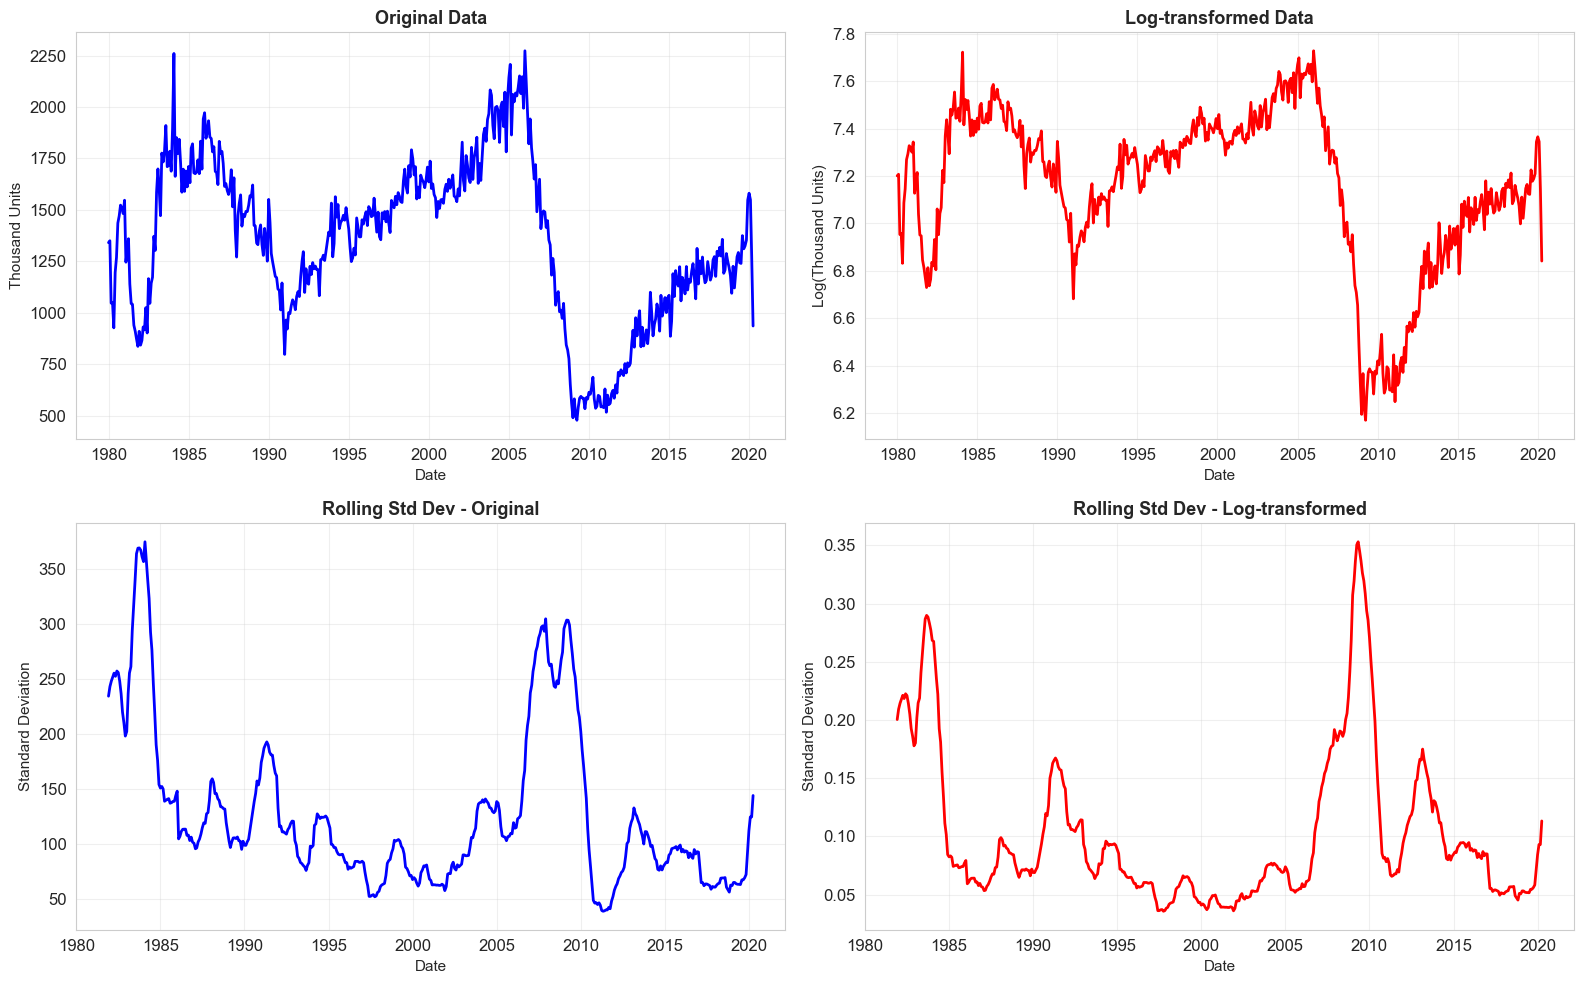

In [16]:
# 예측 성분 분해
components = res_log.forecast_components(12)
print("\n예측 성분 (12개월):")
print(components)

# 로그 변환 효과 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 원본 vs 로그 변환
axes[0, 0].plot(housing.index, housing.values, label='Original',
             color='blue', linewidth=2)
axes[0, 0].set_title('Original Data', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Thousand Units', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(log_housing.index, log_housing.values, label='Log-transformed',
              color='red', linewidth=2)
axes[0, 1].set_title('Log-transformed Data', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Date', fontsize=11)
axes[0, 1].set_ylabel('Log(Thousand Units)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 분산 비교 (이동 분산)
rolling_std_original = housing.rolling(window=24).std()
rolling_std_log = log_housing.rolling(window=24).std()

axes[1, 0].plot(rolling_std_original.index, rolling_std_original.values,
                color='blue', linewidth=2)
axes[1, 0].set_title('Rolling Std Dev - Original', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].set_ylabel('Standard Deviation', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(rolling_std_log.index, rolling_std_log.values,
                color='red', linewidth=2)
axes[1, 1].set_title('Rolling Std Dev - Log-transformed', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Date', fontsize=11)
axes[1, 1].set_ylabel('Standard Deviation', fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
print(f"\n분산 안정화 효과:")
print(f"  Original - Std Dev: {housing.std():.2f}")
print(f"  Log-transformed - Std Dev: {log_housing.std():.4f}")
print(f"  분산 감소 비율: {(1 - log_housing.std()/housing.std())*100:.1f}%")


분산 안정화 효과:
  Original - Std Dev: 388.44
  Log-transformed - Std Dev: 0.3309
  분산 감소 비율: 99.9%


### Performance Comparison: Original vs Log-transformed

In [18]:
# 테스트 데이터 분할
train_size = len(housing) - 24
train_original = housing[:train_size]
test_original = housing[train_size:]
train_log = log_housing[:train_size]
test_log = log_housing[train_size:]

In [19]:
# 1. 원본 데이터 모델
model_original = ThetaModel(train_original)
fit_original = model_original.fit()
forecast_original = fit_original.forecast(24)

# 2. 로그 변환 모델 (Multiplicative)
model_log_mult = ThetaModel(train_log, method="multiplicative")
fit_log_mult = model_log_mult.fit()
forecast_log_mult = fit_log_mult.forecast(24)
forecast_log_mult_backtransformed = np.exp(forecast_log_mult)

# 3. 로그 변환 모델 (Additive)
model_log_add = ThetaModel(train_log, method="additive")
fit_log_add = model_log_add.fit(use_mle=True)
forecast_log_add = fit_log_add.forecast(24)
forecast_log_add_backtransformed = np.exp(forecast_log_add)

In [20]:
# 성능 평가 (원본 스케일에서)
comparison_log = []

for name, forecast in [('Original Scale', forecast_original),
                       ('Log (Multiplicative)', forecast_log_mult_backtransformed),
                       ('Log (Additive)', forecast_log_add_backtransformed)]:
    mae = mean_absolute_error(test_original, forecast)
    rmse = root_mean_squared_error(test_original, forecast)
    mape = mean_absolute_percentage_error(test_original, forecast) * 100

    comparison_log.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

comparison_log_df = pd.DataFrame(comparison_log)
print("모델 성능 비교 (24개월 예측, 원본 스케일):")
print(comparison_log_df.to_string(index=False))

모델 성능 비교 (24개월 예측, 원본 스케일):
               Model        MAE       RMSE     MAPE
      Original Scale 103.901417 141.026166 8.280680
Log (Multiplicative) 103.973187 141.582724 8.278060
      Log (Additive) 103.890008 140.494916 8.333723


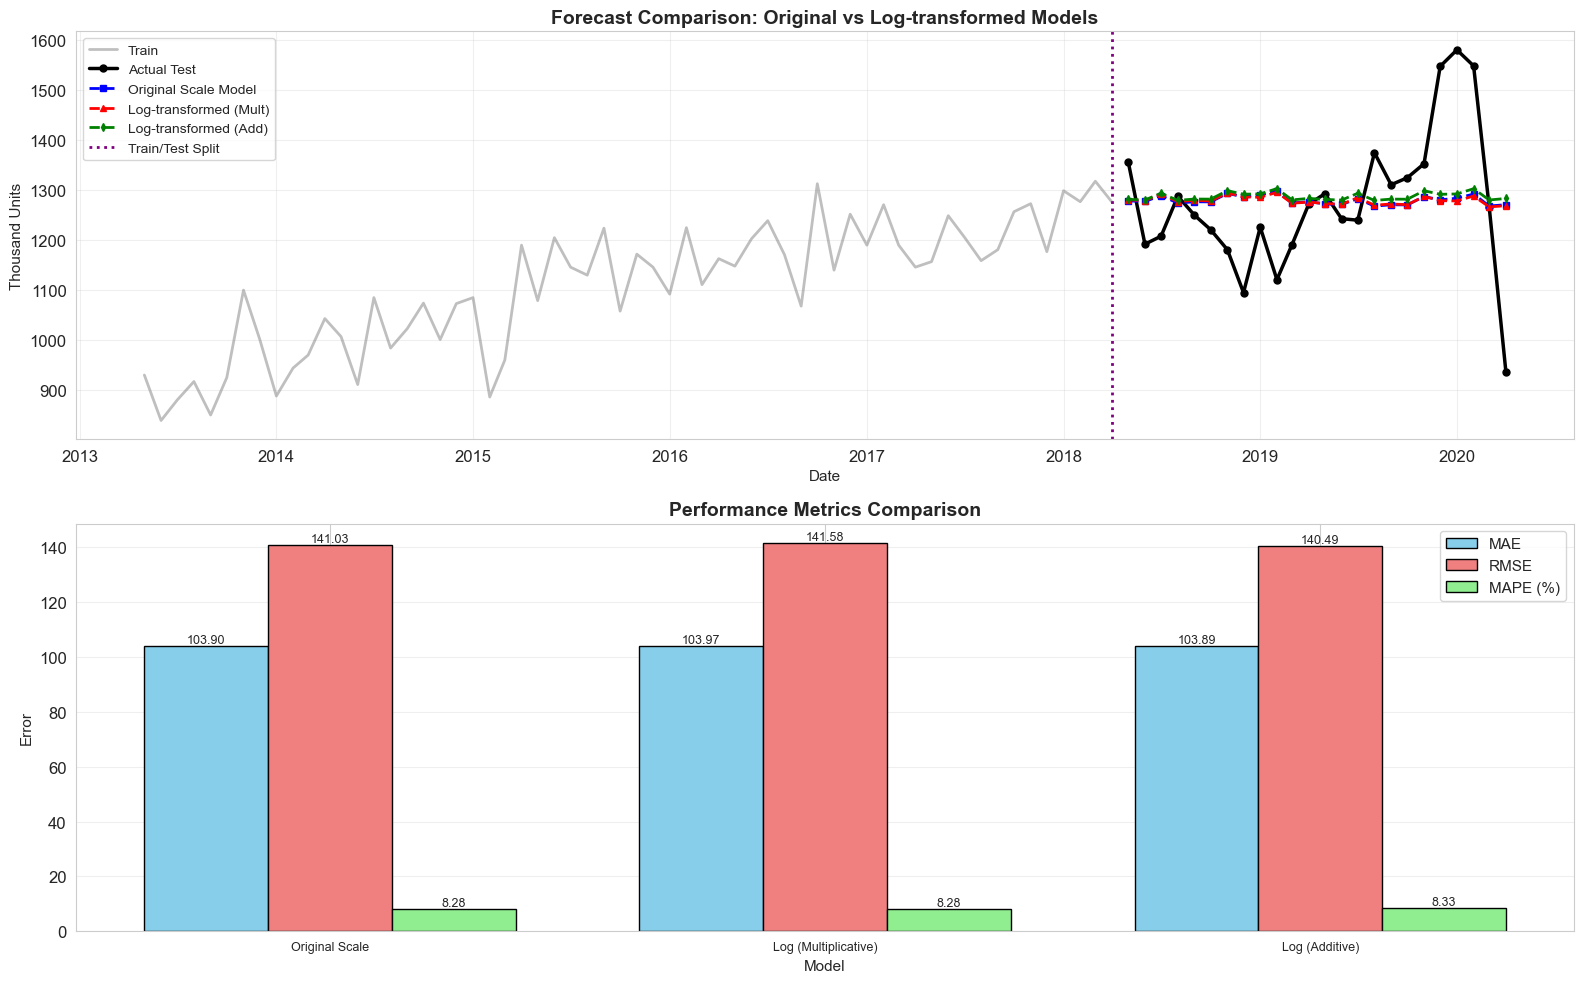

In [21]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 예측 비교
ax1 = axes[0]
ax1.plot(train_original.index[-60:], train_original.values[-60:],
         label='Train', linewidth=2, color='gray', alpha=0.5)
ax1.plot(test_original.index, test_original.values,
         label='Actual Test', linewidth=2.5, color='black', marker='o', markersize=5)
ax1.plot(test_original.index, forecast_original,
         label='Original Scale Model', linewidth=2, linestyle='--',
         marker='s', markersize=4, color='blue')
ax1.plot(test_original.index, forecast_log_mult_backtransformed,
         label='Log-transformed (Mult)', linewidth=2, linestyle='--',
         marker='^', markersize=4, color='red')
ax1.plot(test_original.index, forecast_log_add_backtransformed,
         label='Log-transformed (Add)', linewidth=2, linestyle='--',
         marker='d', markersize=4, color='green')
ax1.axvline(x=train_original.index[-1], color='purple', linestyle=':',
            linewidth=2, label='Train/Test Split')
ax1.set_title('Forecast Comparison: Original vs Log-transformed Models',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Thousand Units', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 성능 지표 비교
ax2 = axes[1]
x = np.arange(len(comparison_log_df))
width = 0.25

bars1 = ax2.bar(x - width, comparison_log_df['MAE'], width,
                label='MAE', color='skyblue', edgecolor='black')
bars2 = ax2.bar(x, comparison_log_df['RMSE'], width,
                label='RMSE', color='lightcoral', edgecolor='black')
bars3 = ax2.bar(x + width, comparison_log_df['MAPE'], width,
                label='MAPE (%)', color='lightgreen', edgecolor='black')

ax2.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xlabel('Model', fontsize=11)
ax2.set_ylabel('Error', fontsize=11)
ax2.set_xticks(x)
ax2.set_xticklabels(comparison_log_df['Model'], fontsize=9)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# 값 표시
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [22]:
# 최적 모델
best_log_model = comparison_log_df.loc[comparison_log_df['RMSE'].idxmin(), 'Model']
print(f"\n최적 모델 (RMSE 기준): {best_log_model}")


최적 모델 (RMSE 기준): Log (Additive)


# Theta Model 시계열 실습 2

개인소비지출 (Personal Consumption Expenditure) 데이터를 활용한 실습 예제.

- 출처: FRED

- 코드: NA000349Q (Personal Consumption Expenditures)

- 기간: 1980-01 ~ 2020-04

- 빈도: Quarterly


## 데이터 로드

In [23]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"

pce_data_path = urljoin(data_repo_url, "personal_consumption_expenditure.csv")
pce = pd.read_csv(pce_data_path, index_col=0, parse_dates=True)
pce.index.freq = "QS-OCT"

In [24]:
pce.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 1980-01-01 to 2020-04-01
Freq: QS-OCT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   PCE     162 non-null    int64
dtypes: int64(1)
memory usage: 2.5 KB


In [25]:
pce.describe()

,PCE
count,1.620000e+02
mean,1.782771e+06
std,9.600881e+05
min,4.145020e+05
25%,9.390615e+05
50%,1.669272e+06
75%,2.559513e+06
max,3.780670e+06


In [26]:
print(f"데이터 shape: {pce.shape}")
print(f"기간: {pce.index[0]} ~ {pce.index[-1]}")

데이터 shape: (162, 1)
기간: 1980-01-01 00:00:00 ~ 2020-04-01 00:00:00


## EDA

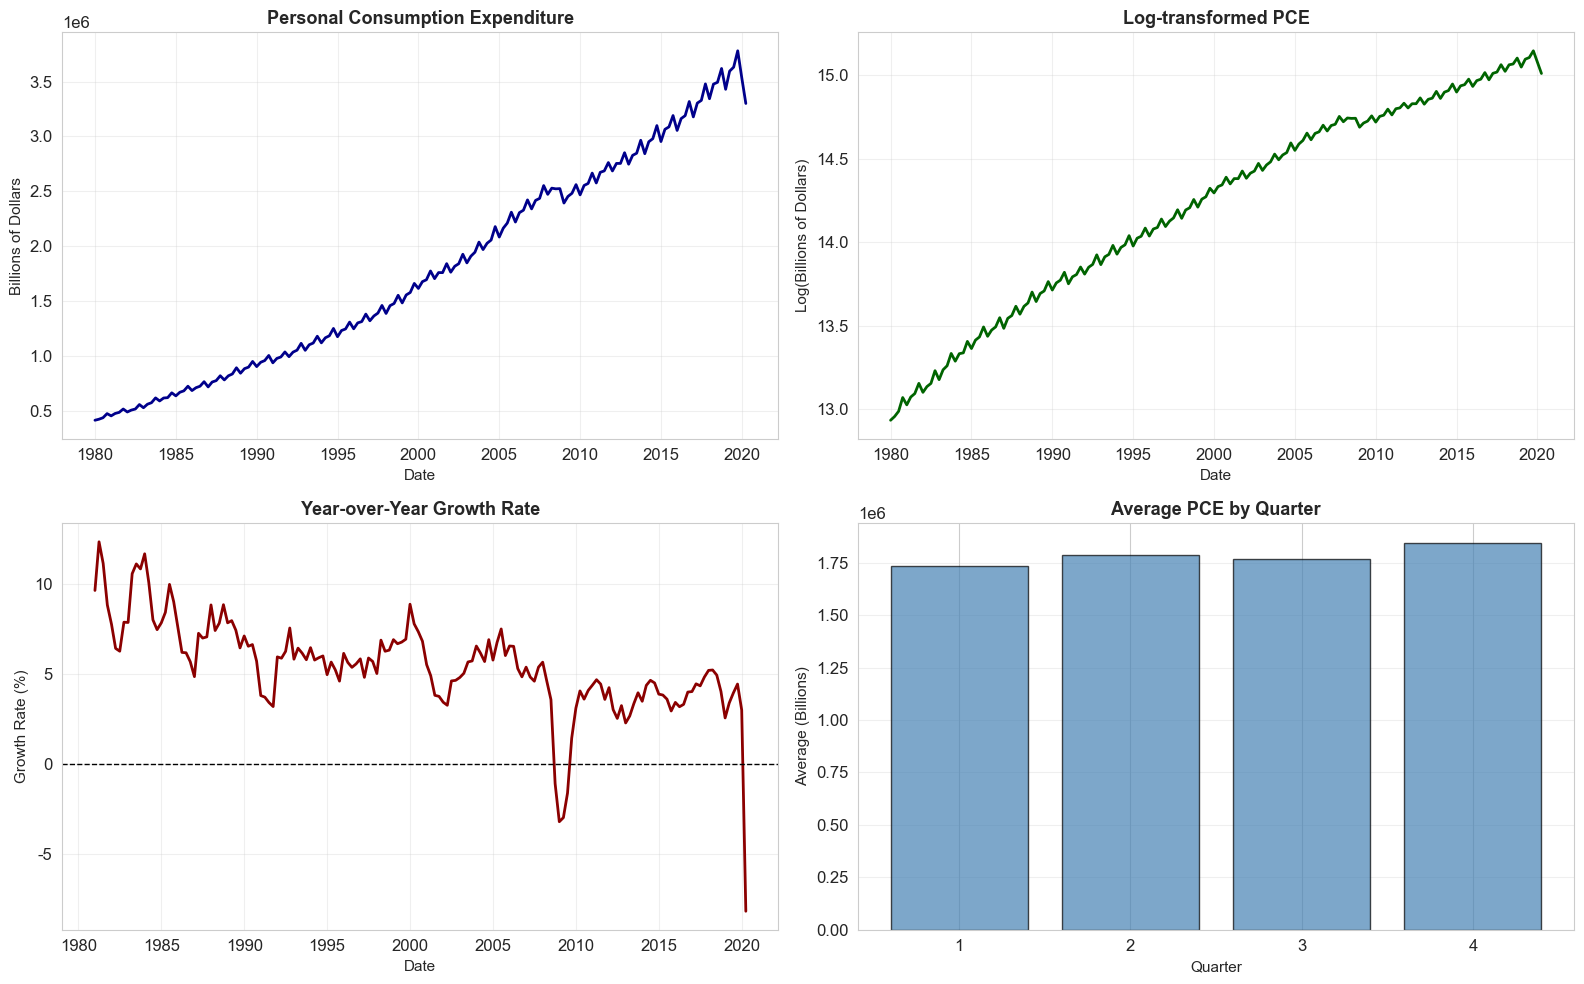

In [27]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 원본 PCE
axes[0, 0].plot(pce.index, pce.PCE, color='darkblue', linewidth=2)
axes[0, 0].set_title('Personal Consumption Expenditure', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=11)
axes[0, 0].set_ylabel('Billions of Dollars', fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 로그 변환 PCE
axes[0, 1].plot(pce.index, np.log(pce.PCE), color='darkgreen', linewidth=2)
axes[0, 1].set_title('Log-transformed PCE', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Date', fontsize=11)
axes[0, 1].set_ylabel('Log(Billions of Dollars)', fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 연간 성장률
pce_growth = pce.PCE.pct_change(4) * 100  # 4 quarters = 1 year
axes[1, 0].plot(pce_growth.index, pce_growth.values, color='darkred', linewidth=2)
axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('Year-over-Year Growth Rate', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Date', fontsize=11)
axes[1, 0].set_ylabel('Growth Rate (%)', fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 분기별 평균
quarterly_avg = pce.groupby(pce.index.quarter).mean()
axes[1, 1].bar(quarterly_avg.index, quarterly_avg.PCE,
               color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Average PCE by Quarter', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Quarter', fontsize=11)
axes[1, 1].set_ylabel('Average (Billions)', fontsize=11)
axes[1, 1].set_xticks([1, 2, 3, 4])
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 다양한 Theta 파라미터 비교

theta 값이 클수록 추세가 강하게 반영됩니다.

In [28]:
# 로그 변환 PCE로 모델 학습
mod_pce = ThetaModel(np.log(pce.PCE))
res_pce = mod_pce.fit()

print(res_pce.summary())

                              ThetaModel Results                              
Dep. Variable:                    PCE   No. Observations:                  162
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Sat, 11 Oct 2025   Deseas. Method:         Multiplicative
Time:                        12:56:17   Period:                              4
Sample:                    01-01-1980                                         
                         - 04-01-2020                                         
   Parameter Estimates    
           Parameters     
--------------------------
b0    0.013035977167087405
alpha    0.999885210197522
--------------------------


In [29]:
# 다양한 theta 값으로 예측
forecast_horizon = 12
ln_pce = np.log(pce.PCE)

forecasts_theta = pd.DataFrame({
    "ln PCE": ln_pce,
    "theta=1.0 (minimal trend)": res_pce.forecast(forecast_horizon, theta=1.0),
    "theta=1.5": res_pce.forecast(forecast_horizon, theta=1.5),
    "theta=2.0 (default)": res_pce.forecast(forecast_horizon, theta=2.0),
    "theta=2.5": res_pce.forecast(forecast_horizon, theta=2.5),
    "theta=3.0": res_pce.forecast(forecast_horizon, theta=3.0),
    "theta=5.0": res_pce.forecast(forecast_horizon, theta=5.0),
    "theta=inf (pure linear)": res_pce.forecast(forecast_horizon, theta=np.inf),
})

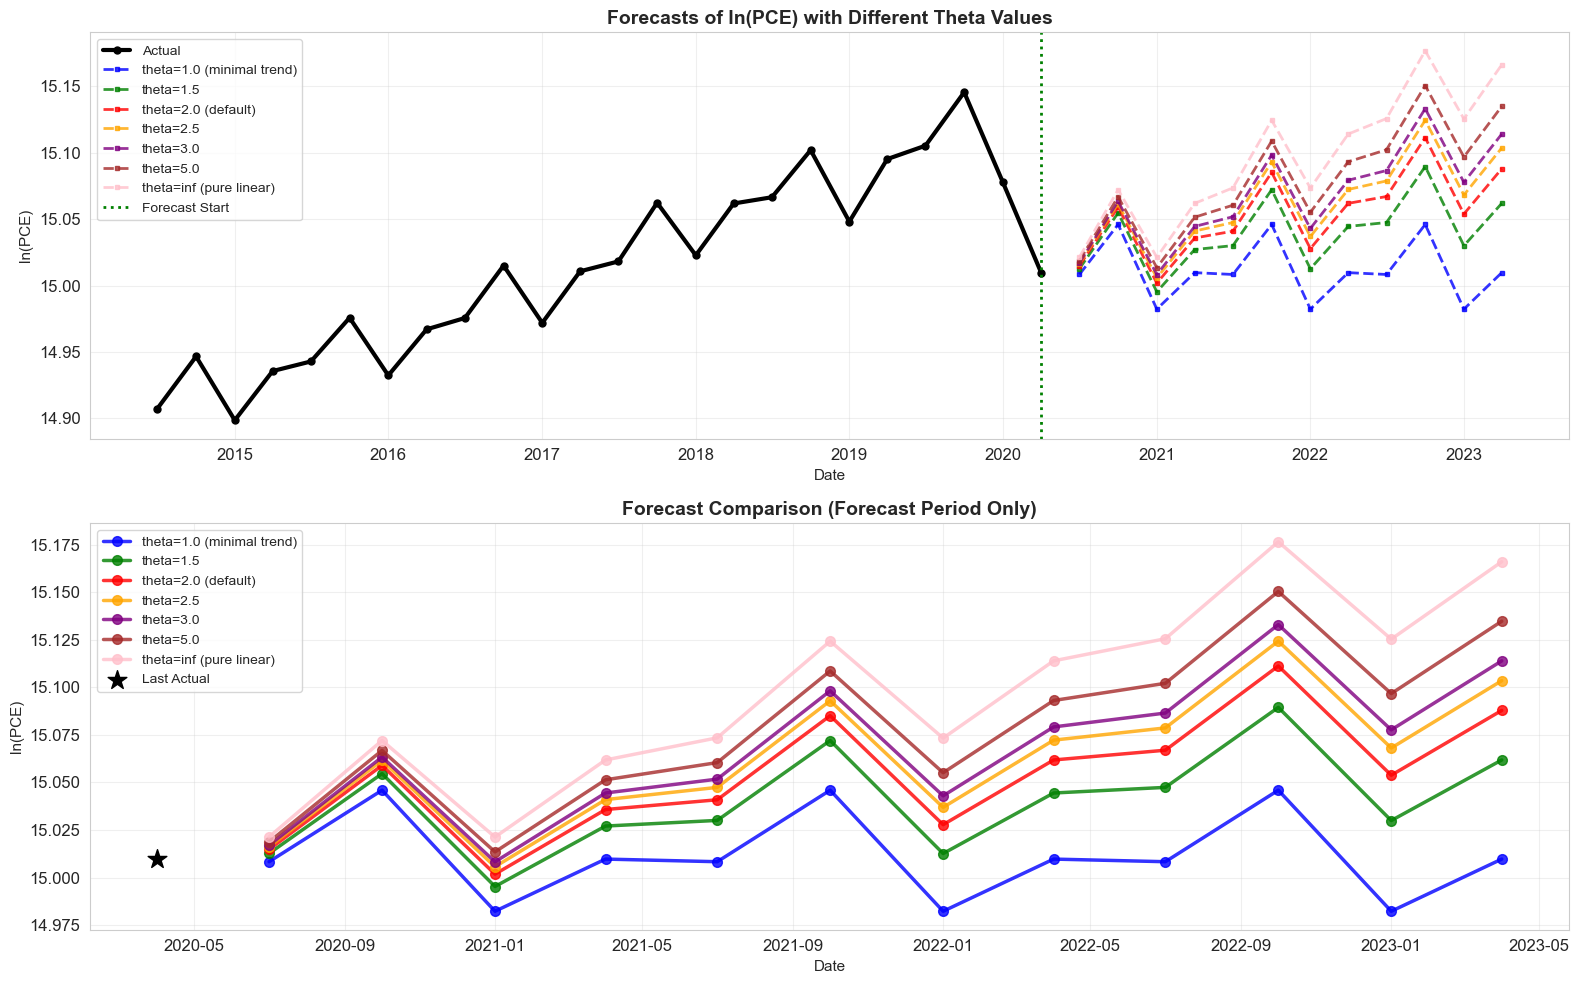

In [30]:
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 최근 36개 분기 + 예측
recent_forecasts = forecasts_theta.tail(36)
ax1 = axes[0]
ax1.plot(recent_forecasts.index, recent_forecasts["ln PCE"],
         label='Actual', linewidth=3, color='black', marker='o', markersize=5)

theta_labels = ["theta=1.0 (minimal trend)", "theta=1.5", "theta=2.0 (default)",
                "theta=2.5", "theta=3.0", "theta=5.0", "theta=inf (pure linear)"]
colors_theta = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

for theta_label, color in zip(theta_labels, colors_theta):
    ax1.plot(recent_forecasts.index, recent_forecasts[theta_label],
             label=theta_label, linewidth=2, linestyle='--',
             color=color, marker='s', markersize=3, alpha=0.8)

ax1.axvline(x=ln_pce.index[-1], color='green', linestyle=':', linewidth=2,
            label='Forecast Start')
ax1.set_title('Forecasts of ln(PCE) with Different Theta Values',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('ln(PCE)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)

# 예측 부분만 확대
forecast_only = forecasts_theta[forecasts_theta.index > ln_pce.index[-1]]
ax2 = axes[1]

for theta_label, color in zip(theta_labels, colors_theta):
    if theta_label in forecast_only.columns:
        ax2.plot(forecast_only.index, forecast_only[theta_label],
                 label=theta_label, linewidth=2.5, marker='o',
                 markersize=7, color=color, alpha=0.8)

# 실제 마지막 값 표시
ax2.scatter(ln_pce.index[-1], ln_pce.iloc[-1],
            s=200, color='black', zorder=5, label='Last Actual', marker='*')

ax2.set_title('Forecast Comparison (Forecast Period Only)',
              fontsize=14, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('ln(PCE)', fontsize=11)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [31]:
# Theta 값별 예측 통계
print("\nTheta 파라미터별 예측값 차이:")
for col in forecasts_theta.columns:
    if col != "ln PCE" and col in forecast_only.columns:
        mean_forecast = forecast_only[col].mean()
        print(f"  {col}: 평균 = {mean_forecast:.4f}")


Theta 파라미터별 예측값 차이:
  theta=1.0 (minimal trend): 평균 = 15.0116
  theta=1.5: 평균 = 15.0398
  theta=2.0 (default): 평균 = 15.0539
  theta=2.5: 평균 = 15.0624
  theta=3.0: 평균 = 15.0680
  theta=5.0: 평균 = 15.0793
  theta=inf (pure linear): 평균 = 15.0963


## 예측 구간 시각화

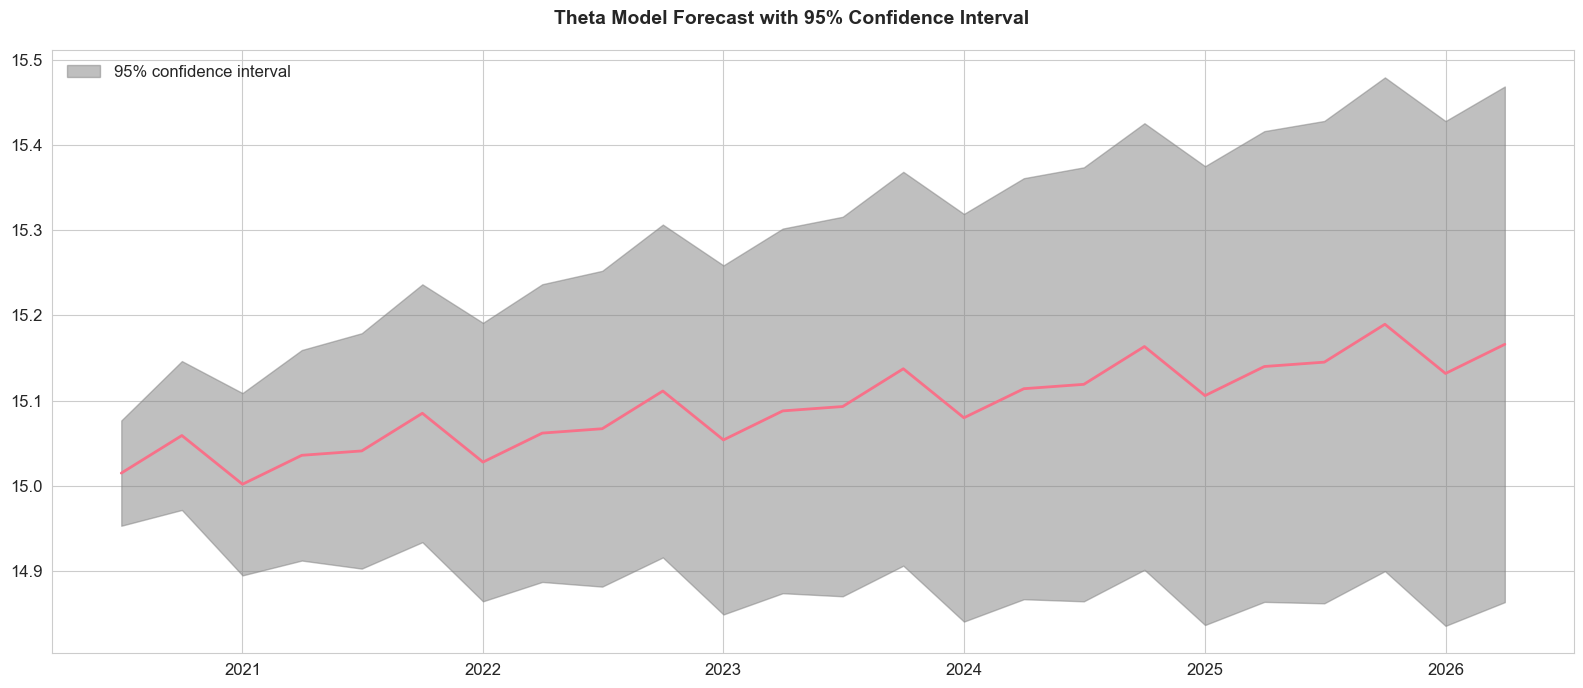

In [32]:
fig = res_pce.plot_predict(24, theta=2)
fig.suptitle('Theta Model Forecast with 95% Confidence Interval',
             fontsize=14, fontweight='bold')
fig.set_size_inches(16, 7)
plt.tight_layout()
plt.show()

## PCE Backtesting - Rolling Forecast

In [33]:
# PCE 백테스팅
ln_pce = np.log(pce.PCE)
forecasts_pce = {"ln PCE": ln_pce}
pce_metrics = []

for year in range(1995, 2020, 3):
    sub_pce = ln_pce[: str(year)]
    res_sub_pce = ThetaModel(sub_pce).fit()
    fcast_pce = res_sub_pce.forecast(12)
    forecasts_pce[str(year)] = fcast_pce

    # 성능 평가
    actual_period_pce = ln_pce[fcast_pce.index[0]:fcast_pce.index[-1]]
    if len(actual_period_pce) > 0:
        mae = mean_absolute_error(actual_period_pce, fcast_pce[:len(actual_period_pce)])
        rmse = root_mean_squared_error(actual_period_pce, fcast_pce[:len(actual_period_pce)])
        mape = mean_absolute_percentage_error(actual_period_pce, fcast_pce[:len(actual_period_pce)]) * 100
        pce_metrics.append({
            'Year': year,
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

forecasts_pce_df = pd.DataFrame(forecasts_pce)


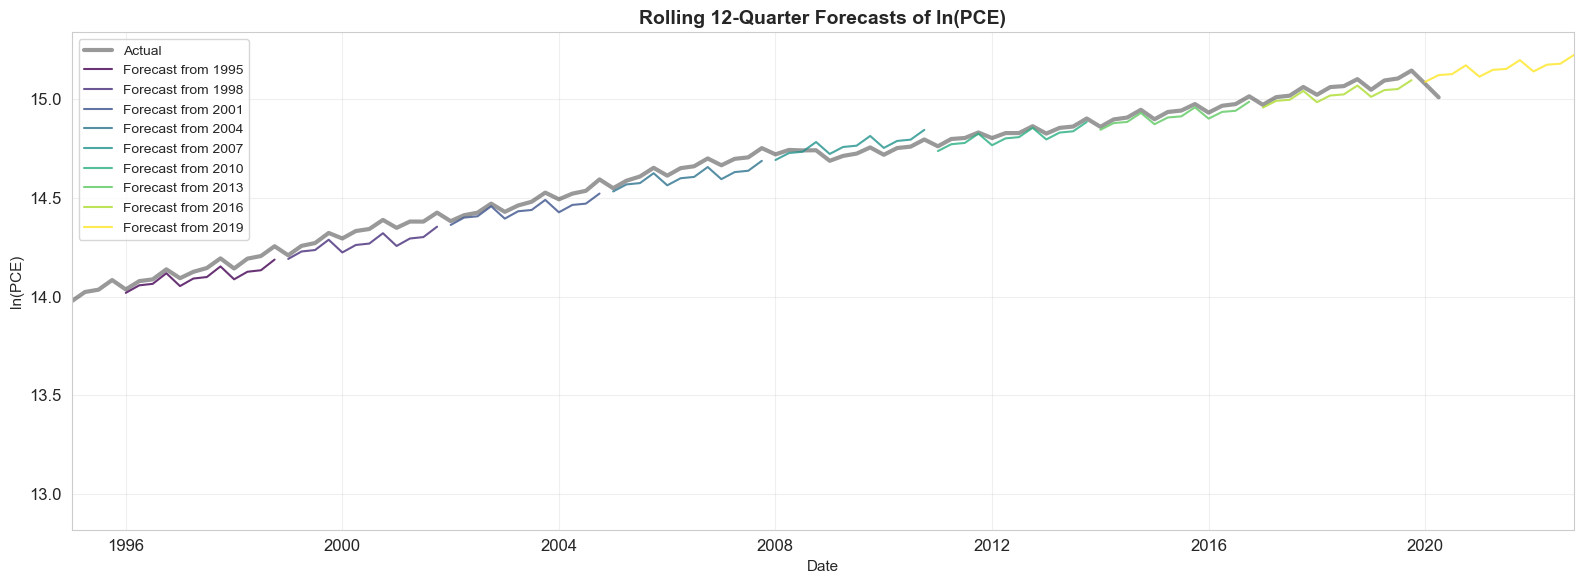

In [34]:
# 시각화
fig, ax1 = plt.subplots(figsize=(16, 6))

# 전체 예측
ax1.plot(forecasts_pce_df.index, forecasts_pce_df["ln PCE"],
         linewidth=3, alpha=0.4, color='black', label='Actual', zorder=1)

colors_pce = plt.cm.viridis(np.linspace(0, 1, len(range(1995, 2020, 3))))
for idx, year in enumerate(range(1995, 2020, 3)):
    if str(year) in forecasts_pce_df.columns:
        ax1.plot(forecasts_pce_df.index, forecasts_pce_df[str(year)],
                linewidth=1.5, alpha=0.8, color=colors_pce[idx],
                label=f'Forecast from {year}', zorder=2)

ax1.set_title('Rolling 12-Quarter Forecasts of ln(PCE)',
              fontsize=14, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('ln(PCE)', fontsize=11)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(forecasts_pce_df.index[forecasts_pce_df.index >= '1995-01-01'].min(),
             forecasts_pce_df.index.max())
plt.tight_layout()
plt.show()



PCE 백테스팅 성능 지표 (12분기 예측):
 Year      MAE     RMSE     MAPE
 1995 0.041826 0.045914 0.295297
 1998 0.060554 0.064951 0.422045
 2001 0.038747 0.043897 0.267161
 2004 0.046946 0.050435 0.320001
 2007 0.035444 0.037842 0.240458
 2010 0.022364 0.023813 0.150851
 2013 0.024473 0.025279 0.163778
 2016 0.034557 0.036862 0.229271
 2019 0.061677 0.080097 0.410754


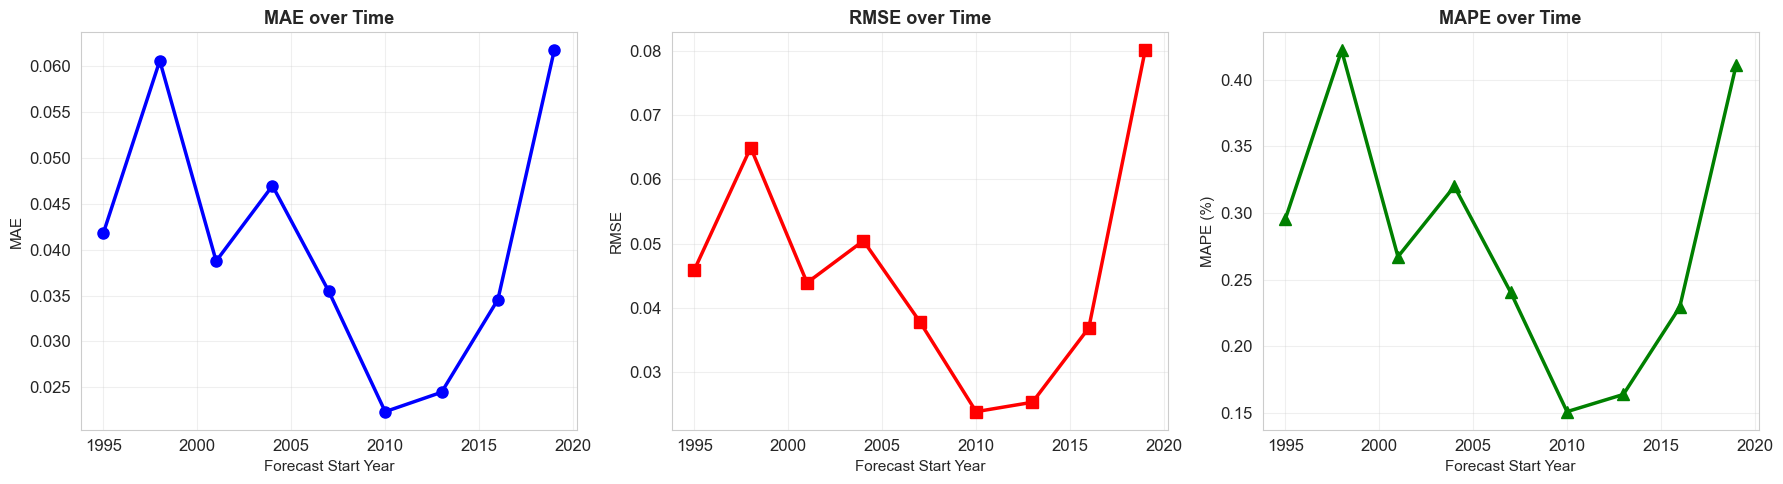

In [35]:
# 성능 지표
if pce_metrics:
    pce_perf_df = pd.DataFrame(pce_metrics)
    print("\nPCE 백테스팅 성능 지표 (12분기 예측):")
    print(pce_perf_df.to_string(index=False))

    # 성능 추이
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(pce_perf_df['Year'], pce_perf_df['MAE'],
                 marker='o', markersize=8, linewidth=2.5, color='blue')
    axes[0].set_title('MAE over Time', fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Forecast Start Year', fontsize=11)
    axes[0].set_ylabel('MAE', fontsize=11)
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(pce_perf_df['Year'], pce_perf_df['RMSE'],
                 marker='s', markersize=8, linewidth=2.5, color='red')
    axes[1].set_title('RMSE over Time', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Forecast Start Year', fontsize=11)
    axes[1].set_ylabel('RMSE', fontsize=11)
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(pce_perf_df['Year'], pce_perf_df['MAPE'],
                 marker='^', markersize=8, linewidth=2.5, color='green')
    axes[2].set_title('MAPE over Time', fontsize=13, fontweight='bold')
    axes[2].set_xlabel('Forecast Start Year', fontsize=11)
    axes[2].set_ylabel('MAPE (%)', fontsize=11)
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Theta Model 요약

Theta Model의 주요 특징:
  - 간단하면서도 효과적인 예측 방법
  - 추세와 수준을 자동으로 분리하여 처리
  - Theta 파라미터로 예측 곡률 조정 가능
  - 로그 변환과 함께 사용 시 비율 예측에 효과적
  - 계산 속도가 빠르고 구현이 간단

적용 분야:
  - 경제 지표 예측 (GDP, 소비, 투자 등)
  - 수요 예측 (판매량, 생산량 등)
  - 금융 시계열 (주가, 환율 등)
  - 인구 통계 예측

Theta vs 다른 모델:
  - ARIMA보다 단순하지만 비슷한 성능
  - ETS 모델의 특수한 경우로 볼 수 있음
  - 계절성이 강한 데이터는 SARIMA나 Holt-Winters가 더 적합

주의사항:
  - 구조적 변화(structural break)에 취약
  - 계절성을 직접 처리하지 못함
  - 외생변수를 포함할 수 없음




## Theta Model vs. TBATS Model

**Theta Model**은 간단하면서도 강력한 시계열 예측 기법입니다.
이 모델은 데이터를 두 개의 ‘Theta line’(하나는 추세를 강조하고, 다른 하나는 평활화된 시계열)을 결합하여 예측을 생성합니다.
기본적으로 단일 지수평활(SES)과 선형 추세 성분을 조합하며, 연산 속도가 빠르고 해석이 직관적입니다.
특히 추세 중심의 단기 예측에서 강점을 보이며, Hyndman 등이 제안한 M3 경쟁에서 우수한 성능을 보인 바 있습니다.
다만, 복잡한 계절성이나 비선형적 패턴을 표현하는 데에는 한계가 있습니다.

**TBATS Model**은 Exponential Smoothing 계열을 확장한 모델로,
Trigonometric, Box-Cox, ARMA errors, Trend, Seasonal components의 약자를 의미합니다.
즉, Box-Cox 변환을 통한 분산 안정화, 여러 주기의 계절성을 포착하는 삼각함수 기반 성분, 그리고 잔차의 ARMA 구조를 포함하여 매우 유연하게 시계열을 표현합니다.
TBATS 모델은 복잡한 다중 계절성(예: 시간별, 주별, 연별)을 가진 데이터나 긴 주기를 포함하는 시계열에 적합합니다.
다만, 계산량이 많고 모수 추정 과정이 복잡하여 학습 시간이 길어질 수 있습니다.

| 구분      | Theta Model                  | TBATS Model                                          |
| ------- | ---------------------------- | ---------------------------------------------------- |
| 핵심 아이디어 | 두 개의 Theta line(추세 + 평활화) 결합 | Exponential Smoothing + Box-Cox + ARMA + 삼각함수 기반 계절성 |
| 계절성 처리  | 단일 주기만 처리 가능                 | 다중 계절성 처리 가능                                         |
| 복잡도     | 낮음                           | 높음                                                   |
| 계산 속도   | 빠름                           | 느림                                                   |
| 해석 가능성  | 높음 (직관적인 구조)                 | 낮음 (복합 구조)                                           |
| 데이터 특성  | 단순 추세형, 안정적 시계열              | 복잡한 계절 패턴, 다주기 구조                                    |
| 장점      | 단순하고 빠르며 안정적인 예측 성능          | 유연하며 다중 계절성과 비선형 패턴까지 표현 가능                          |
| 단점      | 비선형·복합 계절성에 취약               | 해석이 어렵고 계산 비용이 큼                                     |

요약하자면, Theta 모델은 단기 예측이나 단순한 추세형 데이터 분석에 적합하며,
TBATS 모델은 장기 예측이나 다중 계절성을 포함한 복잡한 시계열 분석에 효과적입니다.

Python TBATS 구현은 `tbats` library를 통해 이루어집니다. 다만 numpy 버전 이슈 등이 발생할 수 있어 본 실습에는 포함하지 않았습니다.

- PyPI: https://pypi.org/project/tbats/
- 참고 가능 노트북: https://www.kaggle.com/code/mariavirginiaforcone/power-consumption-forecasting-with-sarima-tbats#Autocorrelation-analysis



# Prophet 실습

Prophet은 Facebook에서 개발한 시계열 예측 라이브러리입니다.

주요 특징:
  - 강력한 계절성(seasonality) 모델링
  - 추세 변화점(changepoints) 자동 감지
  - 휴일(holidays) 효과 반영
  - 결측치와 이상치에 강건
  - 사용하기 쉬운 인터페이스

## 라이브러리 로드

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [37]:
# Prophet 설치: pip install prophet
# 또는: conda install -c conda-forge prophet
try:
    from prophet import Prophet
    print("Prophet imported successfully!")
except ImportError:
    print("Prophet not installed. Please run: pip install prophet")

Prophet imported successfully!


In [38]:
# 시각화 설정
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 2
sns.set_style("whitegrid")

## 2. 데이터 로드 - Peyton Manning Wikipedia 페이지뷰

In [39]:
# 데이터 다운로드
url = 'https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv'
df = pd.read_csv(url)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2905 entries, 0 to 2904
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      2905 non-null   object 
 1   y       2905 non-null   float64
dtypes: float64(1), object(1)
memory usage: 45.5+ KB


In [41]:
df.describe()

,y
count,2905.000000
mean,8.138958
std,0.845957
min,5.262690
25%,7.514800
50%,7.997999
75%,8.580168
max,12.846747


In [42]:
df.head()

,ds,y
0,2007-12-10,9.590761
1,2007-12-11,8.519590
2,2007-12-12,8.183677
3,2007-12-13,8.072467
4,2007-12-14,7.893572


In [43]:
# 날짜 형식 변환
df['ds'] = pd.to_datetime(df['ds'])

## EDA

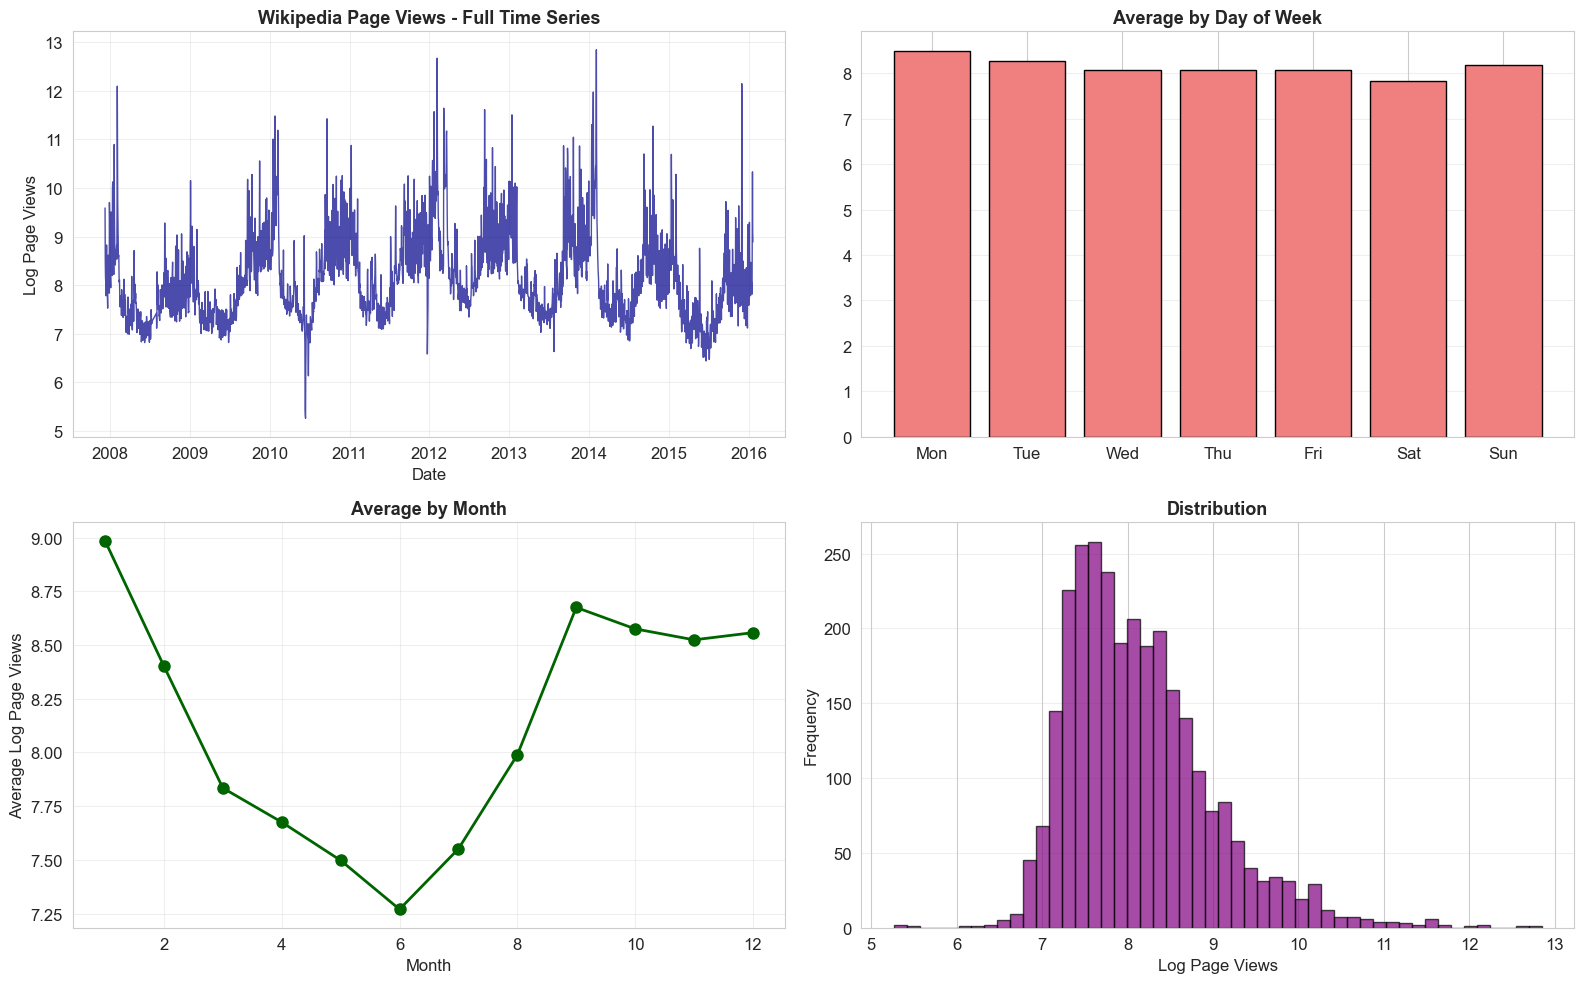

In [44]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 전체 시계열
axes[0, 0].plot(df['ds'], df['y'], color='darkblue', linewidth=1, alpha=0.7)
axes[0, 0].set_title('Wikipedia Page Views - Full Time Series', fontsize=13, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Log Page Views')
axes[0, 0].grid(True, alpha=0.3)

# 요일별 평균
df['dayofweek'] = df['ds'].dt.dayofweek
dow_avg = df.groupby('dayofweek')['y'].mean()
axes[0, 1].bar(range(7), dow_avg.values, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Average by Day of Week', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 월별 평균
df['month'] = df['ds'].dt.month
monthly_avg = df.groupby('month')['y'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='o', markersize=8, color='darkgreen')
axes[1, 0].set_title('Average by Month', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Log Page Views')
axes[1, 0].grid(True, alpha=0.3)

# 히스토그램
axes[1, 1].hist(df['y'], bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Distribution', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Log Page Views')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [45]:
# EDA용 컬럼 제거
df = df[['ds', 'y']]

## 기본 Prophet 모델

In [46]:
# 모델 생성 및 학습
m = Prophet()
m.fit(df)

12:56:19 - cmdstanpy - INFO - Chain [1] start processing
12:56:19 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# 미래 데이터프레임 생성 (365일 예측)
future = m.make_future_dataframe(periods=365)
print(f"예측 기간: 향후 365일")

예측 기간: 향후 365일


In [48]:
# 예측 수행
forecast = m.predict(future)
print(f"\n예측 결과 샘플:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())


예측 결과 샘플:
             ds      yhat  yhat_lower  yhat_upper
3265 2017-01-15  8.204239    7.449158    8.961888
3266 2017-01-16  8.529231    7.782045    9.247601
3267 2017-01-17  8.316611    7.600275    9.076599
3268 2017-01-18  8.149244    7.427249    8.889107
3269 2017-01-19  8.161142    7.446175    8.896200


## 예측 결과 시각화

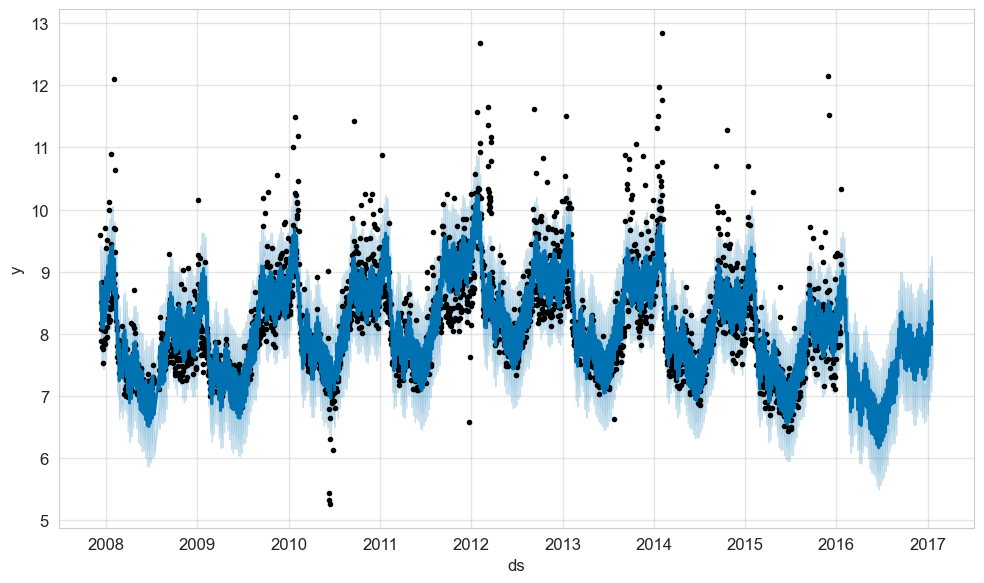

In [49]:
# Prophet 기본 플롯
fig1 = m.plot(forecast)
plt.tight_layout()
plt.show()

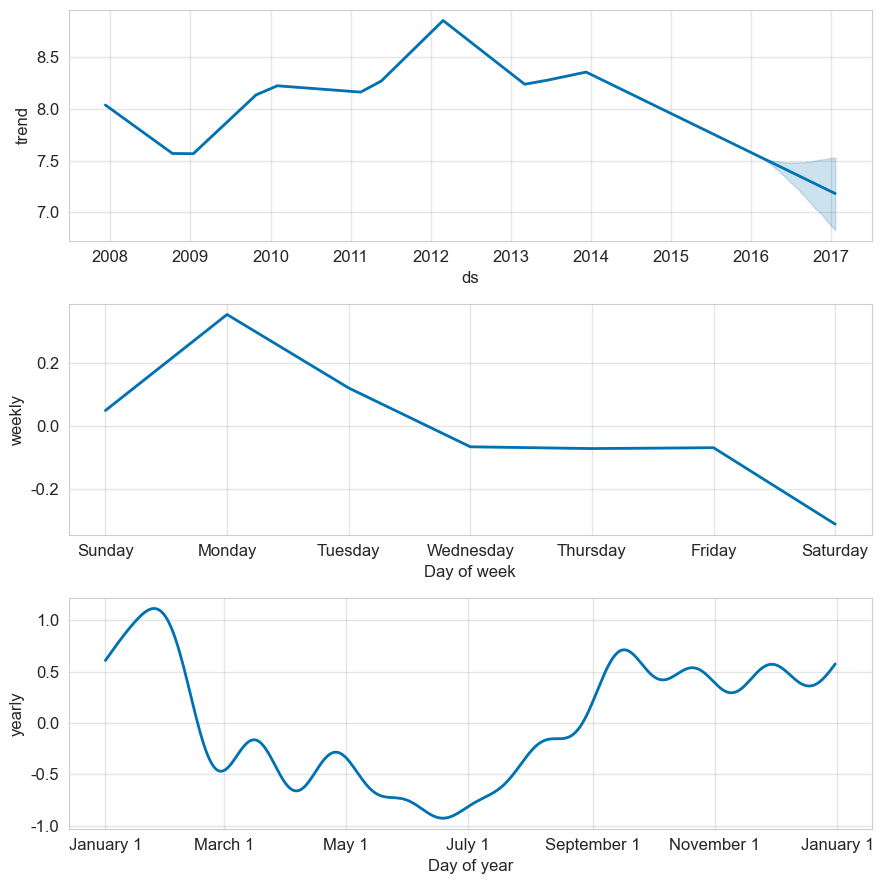

In [50]:
# 성분 분해 플롯
fig2 = m.plot_components(forecast)
plt.tight_layout()
plt.show()

## 성능 평가

In [51]:
# 실제 데이터 기간의 예측값
forecast_insample = forecast[forecast['ds'] <= df['ds'].max()].copy()
forecast_insample = forecast_insample.merge(df, on='ds', how='left')

mae = mean_absolute_error(forecast_insample['y'], forecast_insample['yhat'])
rmse = root_mean_squared_error(forecast_insample['y'], forecast_insample['yhat'])
mape = mean_absolute_percentage_error(forecast_insample['y'], forecast_insample['yhat']) * 100


In [52]:
print("\nIn-sample 예측 성능:")
print(f"  MAE:  {mae:.4f}")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAPE: {mape:.2f}%")


In-sample 예측 성능:
  MAE:  0.3356
  RMSE: 0.4836
  MAPE: 4.00%


## Changepoints 분석

In [53]:
changepoints = m.changepoints
print(f"감지된 변화점 수: {len(changepoints)}")

감지된 변화점 수: 25


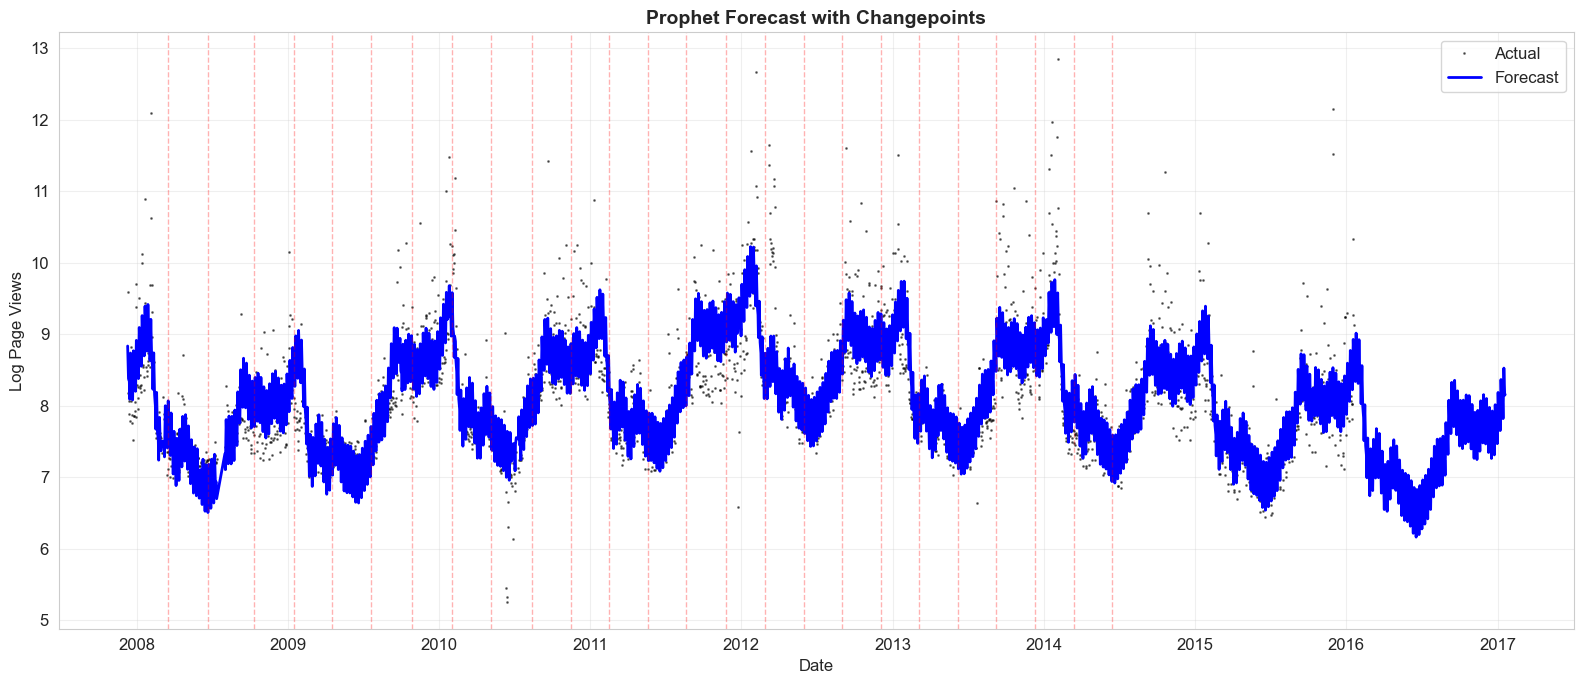

In [54]:
# 변화점 시각화
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(df['ds'], df['y'], 'k.', ms=2, alpha=0.5, label='Actual')
ax.plot(forecast['ds'], forecast['yhat'], 'b-', linewidth=2, label='Forecast')

for cp in changepoints:
    ax.axvline(x=cp, color='red', linestyle='--', alpha=0.3, linewidth=1)

ax.set_title('Prophet Forecast with Changepoints', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Log Page Views')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 계절성 조정 모델

In [55]:
m2 = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=20,
    weekly_seasonality=10,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)

In [56]:
m2.fit(df)
forecast2 = m2.predict(future)

12:56:20 - cmdstanpy - INFO - Chain [1] start processing
12:56:23 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
# 성능 비교
forecast2_insample = forecast2[forecast2['ds'] <= df['ds'].max()].copy()
forecast2_insample = forecast2_insample.merge(df, on='ds', how='left')

mae2 = mean_absolute_error(forecast2_insample['y'], forecast2_insample['yhat'])
rmse2 = root_mean_squared_error(forecast2_insample['y'], forecast2_insample['yhat'])
mape2 = mean_absolute_percentage_error(forecast2_insample['y'], forecast2_insample['yhat']) * 100

In [58]:
print("모델 성능 비교:")
comparison = pd.DataFrame({
    'Model': ['Basic', 'Adjusted'],
    'MAE': [mae, mae2],
    'RMSE': [rmse, rmse2],
    'MAPE': [mape, mape2]
})
print(comparison.to_string(index=False))

모델 성능 비교:
   Model      MAE     RMSE     MAPE
   Basic 0.335626 0.483583 3.997871
Adjusted 0.318136 0.455611 3.791748


## 휴일 효과 추가

In [59]:
# Peyton Manning 플레이오프 및 슈퍼볼
playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
                          '2010-01-24', '2010-02-07', '2011-01-08',
                          '2013-01-12', '2014-01-12', '2014-01-19',
                          '2014-02-02', '2015-01-11', '2016-01-17']),
    'lower_window': 0,
    'upper_window': 1,
})

superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02']),
    'lower_window': 0,
    'upper_window': 1,
})

holidays = pd.concat((playoffs, superbowls))

In [60]:
m3 = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    yearly_seasonality=20,
    weekly_seasonality=10
)

In [61]:
m3.fit(df)
forecast3 = m3.predict(future)

12:56:24 - cmdstanpy - INFO - Chain [1] start processing
12:56:25 - cmdstanpy - INFO - Chain [1] done processing


In [62]:
# 성능 비교
forecast3_insample = forecast3[forecast3['ds'] <= df['ds'].max()].copy()
forecast3_insample = forecast3_insample.merge(df, on='ds', how='left')

mae3 = mean_absolute_error(forecast3_insample['y'], forecast3_insample['yhat'])
rmse3 = root_mean_squared_error(forecast3_insample['y'], forecast3_insample['yhat'])
mape3 = mean_absolute_percentage_error(forecast3_insample['y'], forecast3_insample['yhat']) * 100

In [63]:
print("최종 성능 비교:")
final_comparison = pd.DataFrame({
    'Model': ['Basic', 'Adjusted', 'With Holidays'],
    'MAE': [mae, mae2, mae3],
    'RMSE': [rmse, rmse2, rmse3],
    'MAPE': [mape, mape2, mape3]
})
print(final_comparison.to_string(index=False))

최종 성능 비교:
        Model      MAE     RMSE     MAPE
        Basic 0.335626 0.483583 3.997871
     Adjusted 0.318136 0.455611 3.791748
With Holidays 0.305317 0.432425 3.653617


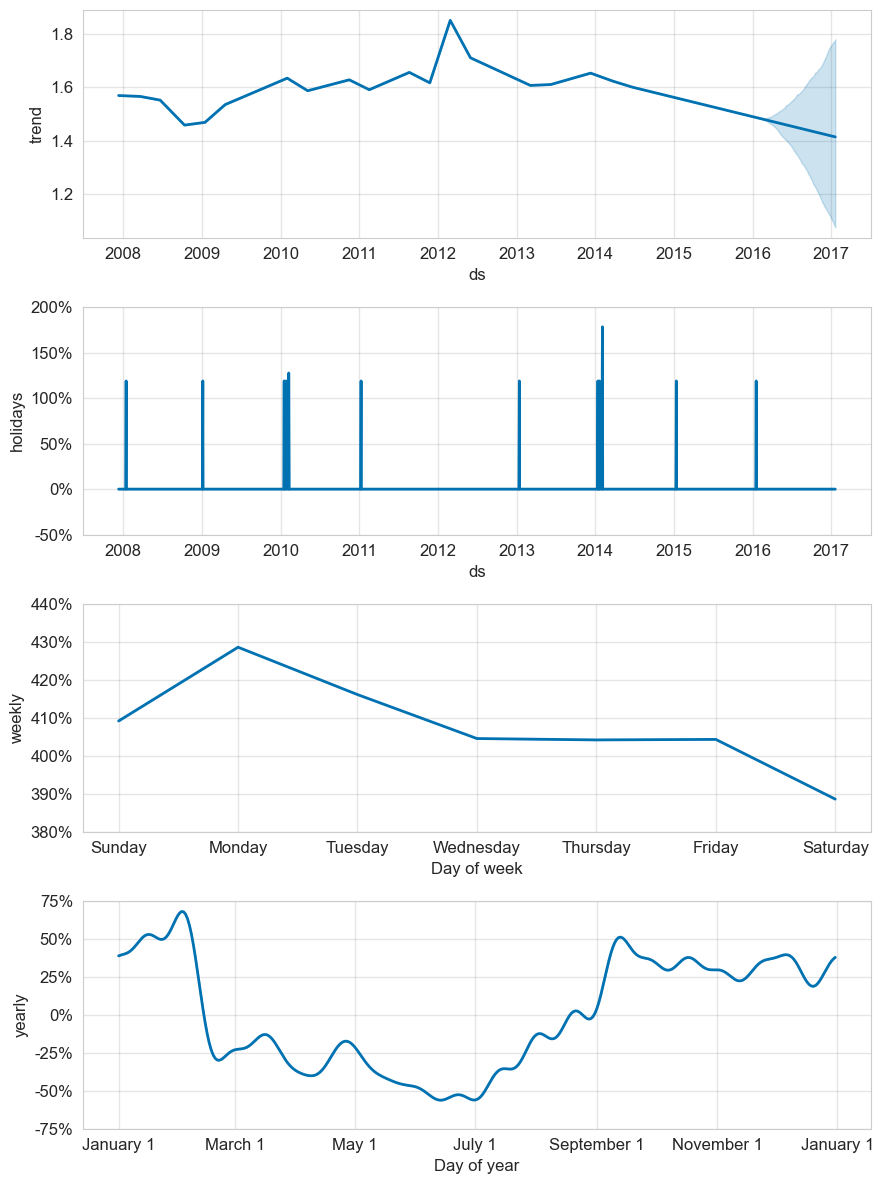

In [64]:
# 성분 분해
fig3 = m3.plot_components(forecast3)
plt.tight_layout()
plt.show()

## Cross-Validation

In [65]:
from prophet.diagnostics import cross_validation, performance_metrics

df_cv = cross_validation(m3, initial='730 days', period='180 days', horizon='365 days')
df_p = performance_metrics(df_cv)

  0%|          | 0/11 [00:00<?, ?it/s]

12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:26 - cmdstanpy - INFO - Chain [1] done processing
12:56:26 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:27 - cmdstanpy - INFO - Chain [1] start processing
12:56:27 - cmdstanpy - INFO - Chain [1] done processing
12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:28 - cmdstanpy - INFO - Chain [1] done processing
12:56:28 - cmdstanpy - INFO - Chain [1] start processing
12:56:29 - cmdstanpy - INFO - Chain [1] done processing
12:56:29 - cmdstanpy - INFO - Chain [1] start processing
12:56:31 - cmdstanpy - INFO - Chain [1] done processing
12:56:31 - cmdstanpy - INFO - Chain [1] start processing
12:56:32 - cmdstanpy - INFO - Chain [1] done processing
12:56:32 - cmdstanpy - INFO - Chain [1] start processing
12:56:33 - cmdstanpy - INFO - Chain [1] done processing
12:56:33 - cmdstanpy - INFO - Chain [1] start processing
12:56:35 - cmdstanpy - INFO - Chain [1]

In [66]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.354049,0.595020,0.419558,0.048652,0.037403,0.048941,0.724532
1,38 days,0.370773,0.608912,0.427930,0.049530,0.038902,0.049909,0.720877
2,39 days,0.394550,0.628132,0.438282,0.050600,0.039148,0.051089,0.715624
3,40 days,0.403103,0.634904,0.441599,0.050968,0.038375,0.051492,0.714481
4,41 days,0.413129,0.642751,0.445889,0.051472,0.039148,0.052026,0.711969
...,...,...,...,...,...,...,...,...
324,361 days,1.022374,1.011125,0.785986,0.090415,0.074775,0.089095,0.880996
325,362 days,1.045453,1.022474,0.792708,0.091028,0.074354,0.089645,0.880996
326,363 days,1.059922,1.029525,0.796504,0.091435,0.074354,0.089953,0.880996
327,364 days,1.069262,1.034051,0.801722,0.092048,0.074775,0.090499,0.882595


In [67]:
print(f"평균 성능 지표:")
print(f"  MAE:  {df_p['mae'].mean():.4f}")
print(f"  RMSE: {df_p['rmse'].mean():.4f}")
print(f"  MAPE: {df_p['mape'].mean():.2f}%")

평균 성능 지표:
  MAE:  0.5593
  RMSE: 0.7328
  MAPE: 0.07%


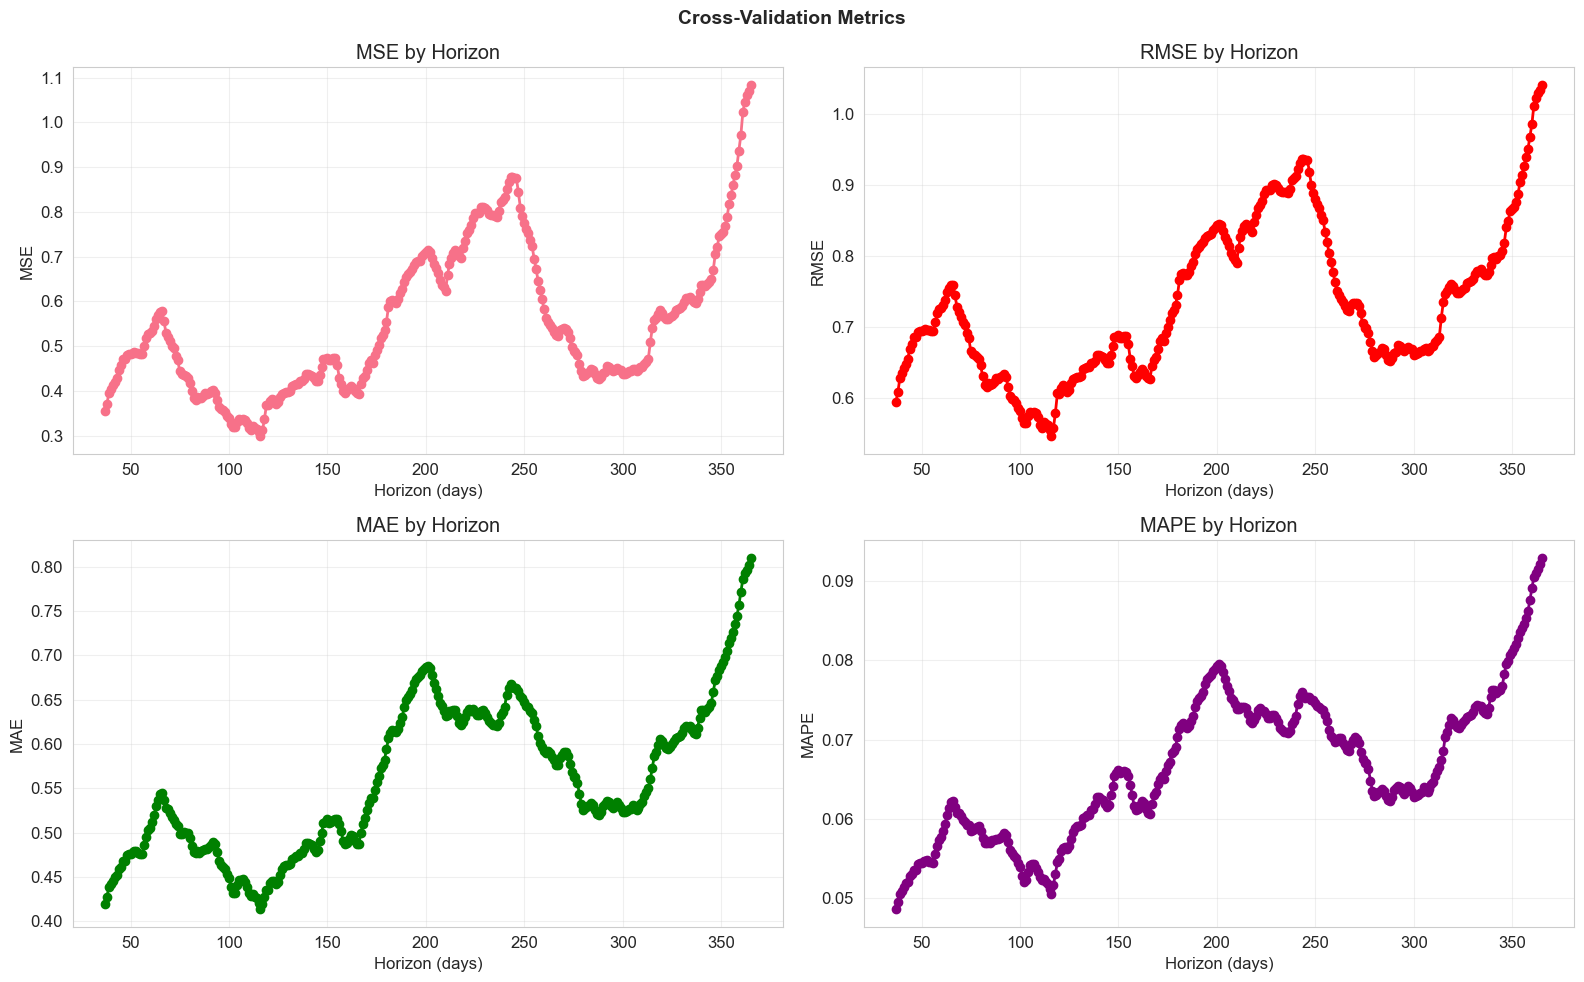

In [68]:
# 성능 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

axes[0, 0].plot(df_p['horizon'].dt.days, df_p['mse'], 'o-')
axes[0, 0].set_xlabel('Horizon (days)')
axes[0, 0].set_ylabel('MSE')
axes[0, 0].set_title('MSE by Horizon')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_p['horizon'].dt.days, df_p['rmse'], 'o-', color='red')
axes[0, 1].set_xlabel('Horizon (days)')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_title('RMSE by Horizon')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(df_p['horizon'].dt.days, df_p['mae'], 'o-', color='green')
axes[1, 0].set_xlabel('Horizon (days)')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].set_title('MAE by Horizon')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(df_p['horizon'].dt.days, df_p['mape'], 'o-', color='purple')
axes[1, 1].set_xlabel('Horizon (days)')
axes[1, 1].set_ylabel('MAPE')
axes[1, 1].set_title('MAPE by Horizon')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Cross-Validation Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [69]:
print("\n최적 모델:", final_comparison.loc[final_comparison['RMSE'].idxmin(), 'Model'])


최적 모델: With Holidays
